# Read and data cleaning

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# from utils.disease_name_mapping import dict_disease_name_mapping
# import utils.disease_name_mapping as dnm
# print(dir(dnm))
### READ DATA ###
df_source = pd.read_csv("data/WWWTable_Epidemics_20250709.csv") # 資訊室提供之資料來源/日期欄位資料 2019~2025-07-09
df_raw = pd.read_csv('data/TCDCIntlEpidAll.csv')
country_mapping = pd.read_excel('data/03輔助用表_監測國家清單.xlsx')
dat_transmission_route_raw = pd.read_excel("data/01總整_01國際疫情資料庫(2017-)_監測疾病清單.xlsx")# 傳染途徑
region_mapping = pd.read_excel('data/03輔助用表_監測國家清單.xlsx', sheet_name="監測國家&區域清單")


### DATA CLEANING ###

df_raw["date"] = pd.to_datetime(df_raw['effective'], errors='coerce').dt.date

research_end_date = pd.to_datetime('2025-07-09').date()
df_raw = df_raw[df_raw['date'] <= research_end_date]


df_raw[['headline_country', 'headline_disease']] = df_raw['headline'].str.split(r'[-－─]', n=1, expand=True) 
    # either half-width - or full-width － or Box-drawing dash ─
df_raw['headline_country'] = df_raw['headline_country'].str.strip()
df_raw['headline_disease'] = df_raw['headline_disease'].str.strip()



df_source = df_source[["Subject","Source","SourceTime","SourceTime2","PublishTime"]]
df_source['SourceTime'] = pd.to_datetime(df_source['SourceTime'], errors='coerce').dt.date #資料來源日期(起)
df_source['SourceTime2'] = pd.to_datetime(df_source['SourceTime2'], errors='coerce').dt.date #資料來源日期(迄)
df_source['PublishTime'] = pd.to_datetime(df_source['PublishTime'], errors='coerce').dt.date
# print(df_source.head(2))

# Merge df_source into df_raw
df_raw = df_raw.merge(df_source, how="left", left_on=["date","headline"], right_on=["PublishTime","Subject"])

# drop useless columns
df_raw = df_raw.drop(
    ["sent", "effective", "source", "expires", "senderName", "instruction", "alert_title", "severity_level", "circle", "headline"], axis=1)#web


#print(df_raw.head(2))


# some date are filled in descriptions or source, requiring efforts to extract them through
view_missing_source_time = df_raw[df_raw['SourceTime'].isna()]
view_missing_source_time['year'] = pd.to_datetime(view_missing_source_time['date']).dt.year
yearly_counts = view_missing_source_time.groupby('year').size().reset_index(name='row_count')
# print(yearly_counts)
# view_missing_source_time.to_csv("missing date.csv")

#disease name frequency
# table_disease_freq = df_raw['headline_disease'].value_counts()
# # print(table_disease_freq.head(5))

# table_alert_disease_freq = df_raw['alert_disease'].value_counts() # alert disease is the original cell for the disease names which require lawful reporting
# # print(table_alert_disease_freq.head(5))



C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_94652\3718384467.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Country names mapping

In [88]:
#####
# (1) Build a mapping using 03輔助用表_監測國家清單.xlsx: each variation matches one ISO3
#####
variation_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1三位代碼']
    if pd.isna(iso3):
        continue  # skip entries without ISO3

    variations = set() # Collect variations from different columns

    if pd.notna(row['監測國家/區域']):
        variations.add(str(row['監測國家/區域']).strip())
    if 'ISO3166-1(中文)' in row and pd.notna(row['ISO3166-1(中文)']):
        variations.add(str(row['ISO3166-1(中文)']).strip())
    if '外網國家別' in row and pd.notna(row['外網國家別']):
        variations.add(str(row['外網國家別']).strip())
    if '中文別稱' in row and pd.notna(row['中文別稱']):
        aliases = str(row['中文別稱']).split('|') # split by '|'
        variations.update([alias.strip() for alias in aliases])

    for var in variations:
        variation_to_iso3[var] = iso3

print(list(variation_to_iso3.items())[:20]) # items is dictionary method that returns a view object containing key-value pairs as tuples.

# Sort mapping by length of variation (descending): Longest variations are checked first, which can prevent confusion such as 馬利 in 索馬利亞
sorted_mapping = sorted(
    variation_to_iso3.items(),  # your dictionary of variation ➔ ISO3
    key=lambda x: len(x[0]),    # sort by length of variation string
    reverse=True                # longest first
)

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()  #Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None
    
    text_remaining = text
    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')# !  # Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

# After extracting a matched variation, remove it from the text to "avoid re-matching shorter substrings" within it.
def extract_country_iso3_from_description(text, sorted_mapping):
    found_iso3 = set()#Automatically remove duplicates if the same country is mentioned multiple times.
    if not isinstance(text, str):
        return None

    text_remaining = text

    # Regex pattern to detect "CountryA 公布 CountryB", where the exclusion condition applies (Country A ≠ Country B)
    pattern_pub = re.compile(r'(\S+?)公布(\S+)')
    match = pattern_pub.search(text_remaining)

    excluded_country = None
    included_country = None
    if match:
        excluded_country = match.group(1).strip() 
        included_country = match.group(2).strip() 

    for var, iso3 in sorted_mapping:
        if var in text_remaining:
            if excluded_country and included_country and var == excluded_country and var != included_country:
                continue 

            found_iso3.add(iso3)
            text_remaining = text_remaining.replace(var, '')#!Remove the matched variation from text_remaining to prevent further substring matches

    return list(found_iso3) if found_iso3 else None

df_raw['description_iso3'] = df_raw['description'].apply(
    lambda x: extract_country_iso3_from_description(x, sorted_mapping))



#####
# (2) Screening the two-value code from ISO3166 to avoid loss of extration
#####

# transform iso2 to iso3
iso2_to_iso3 = {}
for idx, row in country_mapping.iterrows():
    iso2 = row['ISO3166-1二位代碼']
    iso3 = row['ISO3166-1三位代碼']
    if pd.notna(iso2) and pd.notna(iso3):
        iso2_to_iso3[str(iso2).strip()] = str(iso3).strip()

def convert_iso2_to_iso3(iso2_str, mapping_dict):
    if pd.isna(iso2_str):
        return None
    
    iso2_str = str(iso2_str).strip()
    
    iso2_list = [code.strip() for code in iso2_str.split(',')]# Split if multiple codes
    
    iso3_list = [mapping_dict.get(code) for code in iso2_list if mapping_dict.get(code)]
    
    return iso3_list if iso3_list else None

df_raw['ISO3166_to_3code'] = df_raw['ISO3166'].apply(lambda x: convert_iso2_to_iso3(x, iso2_to_iso3))

###
# (3) screening country names from headline
### 
headline_cn_to_iso3 = {}

for idx, row in country_mapping.iterrows():
    iso3 = row['ISO3166-1三位代碼']
    if pd.isna(iso3):
        continue
    # 全球/美洲/歐洲 will be None due to lack of iso3 code
    if pd.notna(row['中文別稱']):
        aliases = [alias.strip() for alias in str(row['中文別稱']).split('|')]
        for alias in aliases:
            headline_cn_to_iso3[alias] = iso3

def map_headline_country_to_iso3(headline_country_str, mapping_dict):
    if pd.isna(headline_country_str):
        return None
    countries = [c.strip() for c in str(headline_country_str).split('/')] #Splits the string by / to get individual countries.
    iso3_list = [mapping_dict.get(c) for c in countries if mapping_dict.get(c)]
    return iso3_list if iso3_list else None

df_raw['headline_country_iso3'] = df_raw['headline_country'].apply(
    lambda x: map_headline_country_to_iso3(x, headline_cn_to_iso3) )

###
# (4) create consolidated country_iso3 by set (description_iso3 and ISO3166_to_3code and headline_country_iso3 )
###
def combine_iso_codes(iso2_3code, description, headline):
    combined_set = set()    
    if isinstance(iso2_3code, list):
        combined_set.update(iso2_3code)
    elif pd.notna(iso2_3code): 
        combined_set.add(iso2_3code)
    
    if isinstance(description, list):
        combined_set.update(description)
    
    if isinstance(headline, list):
        combined_set.update(headline)
    
    return list(combined_set) if combined_set else None

df_raw['country_iso3'] = df_raw.apply(
    lambda row: combine_iso_codes(row['ISO3166_to_3code'], 
                                  row['description_iso3'],
                                  row['headline_country_iso3']),
    axis=1
)

print(df_raw[['ISO3166','ISO3166_to_3code', 'description_iso3', 'headline_country_iso3','country_iso3']].head(10))


[('南極洲', 'ATA'), ('阿富汗', 'AFG'), ('阿爾巴尼亞', 'ALB'), ('阿爾及利亞', 'DZA'), ('美屬薩摩亞', 'ASM'), ('美屬薩摩亞(美屬)', 'ASM'), ('安道爾', 'AND'), ('安哥拉', 'AGO'), ('安吉拉', 'AIA'), ('安吉拉(英屬)', 'AIA'), ('安吉拉(英國海外領地)', 'AIA'), ('安地卡及巴布達', 'ATG'), ('阿根廷', 'ARG'), ('亞美尼亞', 'ARM'), ('阿魯巴', 'ABW'), ('荷屬阿魯巴', 'ABW'), ('阿魯巴(荷屬)', 'ABW'), ('澳大利亞', 'AUS'), ('澳洲', 'AUS'), ('奧地利', 'AUT')]
    ISO3166 ISO3166_to_3code  \
0  AU,IN,ZA  [AUS, IND, ZAF]   
1        BT            [BTN]   
2     CD,TJ       [COD, TJK]   
3        FR            [FRA]   
4     HN,ML       [HND, MLI]   
5     MG,MM       [MDG, MMR]   
6        IN            [IND]   
7        KH            [KHM]   
8       NaN             None   
9       NaN             None   

                                    description_iso3 headline_country_iso3  \
0                                    [IND, ZAF, AUS]       [AUS, IND, ZAF]   
1                                              [BTN]                 [BTN]   
2                                         [TJK, COD]     

In [89]:
# Checks for substring confusion only between different ISO3 codes,

# confusion_list = []

# # Build a list of all variations with their ISO3 code
# variation_iso3_pairs = []

# for idx, row in country_mapping.iterrows():
#     iso3 = row['ISO3166-1三位代碼']
#     if pd.isna(iso3):
#         continue

#     # Process 中文別稱 column
#     if pd.notna(row['中文別稱']):
#         aliases = [alias.strip() for alias in str(row['中文別稱']).split('|')]
#         for alias in aliases:
#             variation_iso3_pairs.append( (alias, iso3) )

# # Check for substring confusion among 中文別稱 variations across different ISO3 codes
# for i, (var1, iso3_1) in enumerate(variation_iso3_pairs):
#     for j, (var2, iso3_2) in enumerate(variation_iso3_pairs):
#         if (
#             i != j 
#             and iso3_1 != iso3_2  # Only between different ISO3 codes
#             and var1 in var2
#         ):
#             confusion_list.append( (var1, var2, iso3_1, iso3_2) )

# # Display potential confusion pairs
# for c in confusion_list:
#     print(f"Alias '{c[0]}' (ISO3: {c[2]}) is substring of '{c[1]}' (ISO3: {c[3]})")


In [90]:
# assess difference 
df_diff = df_raw[
    df_raw.apply(
        lambda row: set(row['ISO3166_to_3code'] or []) != set(row['description_iso3'] or []),
        axis=1
    )
]

# Display result
print(df_diff[['description','ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))

# there is all NA
# df_na = df_diff[df_diff['country_iso3'].isna()]
# print(df_na[['description', 'ISO3166_to_3code', 'description_iso3', 'country_iso3']].head(10))


                                          description  \
7      本週摘要：  \r人類疫情：柬埔寨新增4例H5N1流感人類感染病例。  禽/動物疫情(...   
8   疫情更新：  \r2025年第24週(6/9-15)全球陽性率4.02%，美洲、歐洲、東地中...   
9   疫情更新：  \r2025年第24週(6/9-15)全球陽性率4.02%，美洲、歐洲、東地中...   
10  全球小兒麻痺根除倡議組織(GPEI)公布於6/19-25期間，WPV1新增巴基斯坦1例，cV...   
35  本月更新：  \r全球自2022年6月截至今年6/26累計138國/地區報告15萬195例確...   
36  本週摘要：  \r人類疫情：柬埔寨新增2例H5N1流感人類感染病例。 \r禽/動物疫情(WA...   
38  全球小兒麻痺根除倡議組織(GPEI)公布於6/12-18期間，cVDPV2新增2國共5例，分...   
42       印共4省報告8例，分別分別來自日惹/西爪哇/東努沙登加拉/北蘇拉威西，所有病患均已康復。   
43       印共4省報告8例，分別分別來自日惹/西爪哇/東努沙登加拉/北蘇拉威西，所有病患均已康復。   
51    \r非洲疫情更新，獅子山報告自今年初截至6/17累計4,098例確診病例，其中25例死亡...   

                  ISO3166_to_3code  \
7                            [KHM]   
8                             None   
9                             None   
10            [BEN, ETH, PAK, YEM]   
35  [CHN, COG, ITA, MLI, ARE, GBR]   
36  [BRA, KHM, DNK, DEU, NLD, USA]   
38                      [BEN, ETH]   
42                           [IDN]   
43                           [

### Disease name mapping

In [91]:
## Disease Name Mapping: for main name, sub name
# def clean_heading_disease_name(name):
#     name = re.sub(r'\(.*?\)', '', name)     # 移除括號內的內容
#     name = re.sub(r'^\d+', '', name)    # 去除數字開頭
#     return name.strip()

# df_raw['headline_disease'] = df_raw['headline_disease'].apply(clean_heading_disease_name)

# import sys
# sys.path.append('/utils/disease_name_mapping')

# import my_script

# %run  01_disease_name_mapping.py


dict_disease_name_mapping = { #multiple diseases are splitted by /
    '新型冠狀病毒肺炎': 'COVID-19',  #old name: new name
    '嚴重特殊傳染性肺炎': 'COVID-19',
    "新型冠狀肺炎": "COVID-19", # n=1
    #"新型冠狀病毒": "COVID-19", This is MERS
    "新冠併發重症(每週更新)": 'COVID-19',
    "新冠併發重症(本週更新)": "COVID-19", 
    '新冠併發重症': 'COVID-19',
    "中東呼吸症候冠狀病毒":"中東呼吸症候群冠狀病毒感染症",
    "中東呼吸症候群冠狀定毒":"中東呼吸症候群冠狀病毒感染症",
    "中東呼吸症候群狀病毒":"中東呼吸症候群冠狀病毒感染症",
    "猴痘": "M痘",
    "M痘(每月更新)": "M痘",
    "M痘(每週更新)": "M痘",
    "M痘(本週更新)": "M痘",
    "新型A型流感(每週更新)": "新型A型流感",
    '新型A型流感(本週更新)': "新型A型流感",
    '新型A型流感(H3N2v)': "新型A型流感",
    '新型A型流感(H9N2)' : "新型A型流感",
    "新型A型流感(H9N2/H10N3)": "新型A型流感",
    "新型A型流感(H5N1)": "新型A型流感",
    #"新型A型流感(哺乳動物感染禽流感)": "新型A型流感",
    "新型A型流感(H5)": "新型A型流感",
    "人類H5N1流感": "新型A型流感",
    'H7N9流感': '新型A型流感',
    "H5N1流感": "新型A型流感",
    "H3N8流感": "新型A型流感",
    "H3N1v流感": "新型A型流感",
    "H3N2v流感": "新型A型流感",
    "H5流感":  "新型A型流感",
    "H1N2v流感": "新型A型流感",
    "H5N6流感": "新型A型流感",
    "H9N2流感": "新型A型流感",
    "H3N1v流感": "新型A型流感",
    "H1N2v流感病例": "新型A型流感",
    "H1v流感":  "新型A型流感",
    'H3N2v流感': "新型A型流感",
    'H3N2v、H1N2v流感': "新型A型流感",
    "H1N1v流感": "新型A型流感",
    "H1N2流感": "新型A型流感",
    "H5N8流感": "新型A型流感",
    "H10N3流感" : "新型A型流感",
    "H1N1流感": "新型A型流感",
    "H1N1新型流感": "新型A型流感",
    "─H7N9流感": "新型A型流感",
    "H10N8流感": "新型A型流感",
    "H1N1v 流感": "新型A型流感",
    "H1N1新型流感  ( 加州 德州 )": "新型A型流感",
    "H1N1新型流感 ( 加州 德州 堪薩斯州 紐約 俄亥俄州)": "新型A型流感",
    "H1N1新型流感 ( 加州 德州 堪薩斯州)": "新型A型流感",
    "H1N1新型流感": "新型A型流感",
    "H1N1豬流感": "新型A型流感",
    "H1N2變異株": "新型A型流感",
    "H2N2流感": "新型A型流感",
    "H3N1病毒": "新型A型流感",
    "H3N2V流感": "新型A型流感",
    "H3N2v、H3v流感": "新型A型流感",
    "H3N2豬流感": "新型A型流感",
    "H3流感": "新型A型流感",
    "H3豬流感": "新型A型流感",
    "H5N1、H9N2流感": "新型A型流感",
    "H5N1疫苗": "新型A型流感",
    "H5N2高病原性禽流感": "新型A型流感",
    "H5N6、H7N9流感": "新型A型流感",
    "H7N2流感": "新型A型流感",
    "H7N4流感": "新型A型流感",
    "H7N7流感": "新型A型流感",
    "H7N9": "新型A型流感",
    "H7N9、H5N6流感": "新型A型流感",
    "H7流感": "新型A型流感",
    "H7禽流感": "新型A型流感",
    "H9流感": "新型A型流感",
    "新型A型流感(哺乳動物感染禽流感)":"新型A型流感",
    "新型A型流感(疫苗)":"新型A型流感",
    "新型A流感":"新型A型流感",
    "人類H5N1流感" :"新型A型流感",
    "人類禽流感":"新型A型流感",
    "新型Ａ型流感(哺乳動物感染禽流感)":"新型Ａ型流感",
    "流感、新型A型流感":"流感/新型A型流感",
    "Echovirus 30 (E30)": "腸病毒",
    '1腸道菌感染症': '腸道菌感染症',
    # "病毒性腸胃炎(諾羅病毒)": "",
    "病毒性腸胃炎(沙門氏菌)": "沙門氏菌感染症",
    "沙門氏菌症":"沙門氏菌感染症",
    "沙門氏桿菌":"沙門氏菌感染症",
    "沙門氏菌感染": "沙門氏菌感染症",
    "抗藥性沙門氏菌": "沙門氏菌感染症",
    "沙門氏菌": "沙門氏菌感染症",
    "克羅諾菌與沙門氏菌感染": "克羅諾菌/沙門氏菌感染症",
    "沙門氏菌(Salmonella Agbeni)": "沙門氏菌感染症",
    "細菌性腸胃炎(沙門氏菌)": "沙門氏菌感染症",
    "細菌性腸胃炎(曲狀桿菌/沙門氏菌)": "細菌性腸胃炎(曲狀桿菌)/沙門氏菌感染症",
    "曲狀桿菌": "細菌性腸胃炎(曲狀桿菌)",
    "多重抗藥性曲狀桿菌": "細菌性腸胃炎(曲狀桿菌)",
    "大腸桿菌、彎曲桿菌":"大腸桿菌感染症/彎曲桿菌",
    "廣泛抗藥性大腸桿菌":"大腸桿菌感染症",
    "大腸桿菌感染":"大腸桿菌感染症",
    "布氏桿菌":"布氏桿菌病",
    "不明原因腹瀉": "腹瀉", # pending
    "輪狀病毒感染":"輪狀病毒",
    "不明原因疾病死亡": "不明原因致死疾病",
    "不明原因死亡": "不明原因致死疾病",
    "不明原因死亡、黃熱病" : "不明原因致死疾病/黃熱病",
    "不明原因致死疾病(疑似炭疽病)": "不明原因致死疾病",
    "不明原因疾病(急性腹瀉與嘔吐)": "不明原因疾病",
    "不明原因呼吸道感染":"不明原因疾病",
    "不明原因神經系統畸形": "不明原因疾病",
    "不明原因肺炎": "不明原因疾病",
    "不明原因神經系統疾病":"不明原因疾病",
    '不明原因腦脊髓膜炎': "不明原因疾病",
    "不明原因出血": "不明原因疾病",
    "不明原因出血熱": "不明原因疾病",
    "不明原因疾病(番茄流感)":  "不明原因疾病",
    "不明原因出血疾病": "不明原因疾病", 
    "不明原因急性肝炎": "不明原因疾病",
    "不明蟲媒發熱疾病": "不明原因疾病",
    "不明原因腦炎與細菌性腦膜炎": "不明原因疾病",
    "不明原因腦膜炎": "不明原因疾病",
    "不明原因急性腎衰竭": "不明原因疾病",
    "不明原因肝炎": "不明原因疾病",
    "不明原因急性腎衰竭": "不明原因疾病",
    "不明原因呼吸道疾病": "不明原因疾病",
    "不明原因腦膜炎": "不明原因疾病",
    "不明原因出血熱、瘧疾": "不明原因疾病/瘧疾",
    "不明原因呼吸道感染": "不明原因疾病",
    "兒童急性嚴重不明原因肝炎": "不明原因疾病",
    "不明原因呼吸道疾病": "不明原因疾病",
    "不明原因出血熱": "不明原因疾病", 
    "不明原因肺炎": "不明原因疾病",
    "不明原因發病": "不明原因疾病",
    "不明疾病" :"不明原因疾病",
    "不明蟲媒發熱疾病": "不明原因疾病",
    "不明病因皮膚病" :"不明原因疾病",
    "不明原因神經系統畸形" : "不明原因疾病",
    "不明原因腦炎": "不明原因疾病",
    "不明皮膚疾病" : "不明原因疾病",
    "不明皮膚病":"不明原因疾病",
    "兒童急性嚴重不明原因肝炎": "不明原因疾病",
    "人類免疫缺乏病毒感染": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV感染": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV": "人類免疫缺乏病毒(愛滋病毒)感染",
    "HIV/AIDS": "人類免疫缺乏病毒(愛滋病毒)感染",
    "愛滋病": "人類免疫缺乏病毒(愛滋病毒)感染",
    "梅毒與先天性梅毒": "梅毒/先天性梅毒",
    "猩紅熱與侵襲性A群鏈球菌感染": "猩紅熱與A群鏈球菌感染",
    "猩紅熱與侵襲性A群鏈球菌感染症": "猩紅熱與A群鏈球菌感染",
    "猩紅熱及侵襲性A型鏈球菌感染": "猩紅熱與A群鏈球菌感染",
    "溶血性A群鏈球菌感染": "A群鏈球菌感染",
    "侵襲性A群鏈球菌": "A群鏈球菌感染",
    "克里米亞剛果出血熱": "克里米亞-剛果出血熱",
    "克里米-亞剛果出血熱": "克里米亞-剛果出血熱",
    "立百病毒": "立百病毒感染症",
    "立百病毒感染": "立百病毒感染症",
    "立百病毒(Nipah Virus)":"立百病毒感染症",
    "漢他病毒": "漢他病毒症後群",
    "漢他病毒感染症": "漢他病毒症後群",
    "漢他病毒出血熱": "漢他病毒症後群",
    "漢他病毒肺症候群": "漢他病毒症後群",
    "皮膚利什曼原蟲症" : "利什曼原蟲症", 
    "萊姆病、蜱媒腦炎": "萊姆病/蜱媒腦炎",
    "水痘/A型肝炎":"水痘/急性病毒性A型肝炎",
    "E型肝炎": "急性病毒性E型肝炎",
    "A型肝炎": "急性病毒性A型肝炎",
    "B型肝炎": "急性病毒性B型肝炎",
    "C型肝炎": "急性病毒性B型肝炎",
    "E型肝炎病例": "急性病毒性E型肝炎",
    "中東呼吸症候群冠狀病毒": "中東呼吸症候群冠狀病毒感染症",
    "發熱伴血小板減少綜合症(SFTS)":"發熱伴血小板減少綜合症",
    "傳染性紅斑": "傳染性紅斑症",
    "人類間質肺炎病毒(HMPV)": "人類間質肺炎病毒感染",
    "人類間質肺炎": "人類間質肺炎病毒感染",
    "人類間質肺炎病毒": "人類間質肺炎病毒感染",
    "伊波拉病毒": "伊波拉病毒感染", # Sudan病毒疾病是伊波拉病毒感染的一種
    "伊波拉出血熱" : "伊波拉病毒感染",
    "伊波拉病毒感染症" : "伊波拉病毒感染",
    "伊波拉病毒出血熱":"伊波拉病毒感染",
    "剛果出血熱死": "剛果出血熱",
    "急性無力脊髓炎(Acute Flaccid Myelitis, AFM)": "急性無力脊髓炎",
    "巴利症候群": "格林巴利症候群",
    "巴利症候群(GBS)": "格林巴利症候群",
    "ZIKA病毒": "茲卡病毒感染",
    "茲卡病毒": "茲卡病毒感染",
    "Zika病毒": "茲卡病毒感染",
    "5腸道菌感染症": "腸道菌感染症",
    "4腸道菌感染症": "腸道菌感染症",
    "西尼羅病毒": "西尼羅熱",
    "李斯特菌": "李斯特菌症",
    "1綠膿桿菌感染症": "綠膿桿菌感染症",
    "侵襲性b型嗜血桿菌" : "侵襲性b型嗜血桿菌感染症",
    "侵襲性b型嗜血桿菌感染症病例" : "侵襲性b型嗜血桿菌感染症", 
    "侵襲性ｂ型嗜血桿菌":"侵襲性b型嗜血桿菌感染症",
    "侵襲性ｂ型嗜血桿菌感染症":"侵襲性b型嗜血桿菌感染症",
    "侵襲性肺炎鏈球菌" : "侵襲性肺炎鏈球菌感染症",
    "侵襲性肺炎鏈球菌感染症死" :"侵襲性肺炎鏈球菌感染症",
    "人類副腸孤病毒":"人類副腸孤病毒(PeV)",
    "傷寒、副傷寒":"傷寒/副傷寒",
    "克里米亞-剛果出血熱死" :"克里米亞-剛果出血熱",
    "出血熱、瘧疾" :"出血熱/瘧疾",
    "利什曼病":"利什曼原蟲症",
    "創傷弧菌":"創傷弧菌感染",
    "呼吸道疾病":"呼吸道傳染病",
    "哈特蘭病毒(Heartland Virus)":"哈特蘭病毒",
    "急性無力脊髓炎(AFM)":"急性無力脊髓炎",
    "小兒痲痺" :"小兒痲痺症",
    "小兒痲痺病毒":"小兒痲痺症",
    "小兒麻痺":"小兒痲痺症",
    "小兒麻痺病毒":"小兒痲痺症",
    "小兒麻痺症病例":"小兒痲痺症",
    "小頭畸型、茲卡病毒感染症":"茲卡病毒感染症",
    "小頭畸形":"茲卡病毒感染症",
    "小頭症":"茲卡病毒感染症",
    "小頭症、格林-巴利症候群(GBS)":"茲卡病毒感染症/格林-巴利症候群(GBS)",
    "小頭症、茲卡病毒感染症":"茲卡病毒感染症",
    "格林-巴利症候群(GBS)、茲卡病毒感染症":"格林-巴利症候群(GBS)/茲卡病毒感染症",
    "格林-巴利症候群、茲卡病毒感染":"格林-巴利症候群(GBS)/茲卡病毒感染症",
    "茲卡病毒感染":"茲卡病毒感染症",
    "茲卡病毒感染症、GBS":"茲卡病毒感染症/格林-巴利症候群(GBS)",
    "茲卡病毒感染症、小頭症":"茲卡病毒感染症",
    "茲卡病毒感染症、小頭症、GBS":"茲卡病毒感染症",
    "屈公病、登革熱":"屈公病/登革熱",
    "巴貝氏蟲病":"巴貝氏蟲症",
    "庫賈氏症":"庫賈氏病",
    "廣東住血線蟲":"廣東住血線蟲感染症",
    "廣泛抗藥性(XDR)傷寒":"廣泛抗藥性傷寒(XDR)",
    "廣泛抗藥性傷寒":"廣泛抗藥性傷寒(XDR)",
    "性病":"性傳染病",
    "手口足病":"手足口病",
    "抗萬古黴素腸道鏈球菌":"抗萬古霉素腸道鏈球菌",
    "旋毛蟲病":"旋毛蟲感染症",
    "李斯特桿菌":"李斯特菌症",
    "李斯特氏菌":"李斯特菌症",
    "東部馬腦炎":"東方馬腦炎",
    "水痘、猩紅熱":"水痘/猩紅熱",
    "波旁病毒":"波旁病毒感染",
    "波瓦尚病毒感染":"波瓦尚病毒",
    "波瓦桑病毒":"波瓦尚病毒",
    "波瓦桑病毒性腦炎":"波瓦尚病毒",
    "洛磯山斑點熱":"洛磯山斑疹熱",
    "流感疫苗":"流感",
    "流感病毒變異株":"流感",
    "流行性腦脊髓":"流行性腦脊隨膜炎",
    "流行性角結膜炎、急性出血性結膜炎":"流行性角結膜炎/急性出血性結膜炎",
    "漢他病毒、鉤端螺旋體病":"漢他病毒/鉤端螺旋體病",
    "漢他病毒感染":"漢他病毒症候群",
    "炭疽":"炭疽病",
    "炭疽桿菌":"炭疽病",
    "牛痘":"牛痘病毒",
    "犬心絲蟲病":"犬心絲蟲感染症",
    "玻那病毒":"玻那病毒感染",
    "球黴菌溪谷熱":"球黴菌症",
    "環孢子症":"環孢子蟲症",
    "環孢子蟲病":"環孢子蟲症",
    "環孢子蟲":"環孢子蟲症",
    "疑似腸病毒":"腸病毒",
    "疥瘡":"疥瘡感染症",
    "登革":"登革熱",
    "登革熱、茲卡病毒感染症":"登革熱/茲卡病毒感染症",
    "登革熱和麻疹":"登革熱麻疹",
    "登革熱疫苗":"登革熱",
    "福氏內格里阿米巴原蟲":"福氏內格里阿米巴腦膜腦炎",
    "福氏內格里阿米巴腦膜炎":"福氏內格里阿米巴腦膜腦炎",
    "福氏內格阿米巴腦膜腦炎":"福氏內格里阿米巴腦膜腦炎",
    "福氏耐格里阿米巴":"福氏內格里阿米巴腦膜腦炎",
    "福氏耐格里阿米巴原蟲":"福氏內格里阿米巴腦膜腦炎",
    "綠膿桿菌":"綠膿桿菌感染",
    "綠膿桿菌感染症":"綠膿桿菌感染",
    "羅斯河病毒":"羅斯河病毒感染",
    "羅絲河病毒":"羅斯河病毒感染",
    "聖路易腦炎":"聖路易斯腦炎",
    "肉毒桿菌":"肉毒桿菌中毒",
    "肺結核":"結核病",
    "腦炎、日本腦炎":"腦炎/日本腦炎",
    "腦炎及日本腦炎":"腦炎/日本腦炎",
    "腸病毒、諾羅病毒":"腸病毒/諾羅病毒",
    "腸胃炎、諾羅病毒":"腸胃炎/諾羅病毒",
    "諾羅病毒感染":"諾羅病毒",
    "腸道出血大腸桿菌感染症":"腸道出血性大腸桿菌感染症",
    "腸道出血性大腸桿菌":"腸道出血性大腸桿菌感染症",
    "腸道出血性大腸桿菌感染症(O26)":"腸道出血性大腸桿菌感染症",
    "腹瀉、傷寒":"腹瀉/傷寒",
    "腺病毒感染":"腺病毒",
    "蜱傳腦炎":"蜱媒腦炎",
    "蠅蛆病":"蠅蛆症",
    "血吸蟲":"血吸蟲病",
    "血吸蟲症":"血吸蟲病",
    "西尼羅河病毒":"西尼羅熱",
    "詹姆斯峽谷病毒":"詹姆斯敦峽谷病毒",
    "詹姆斯敦峽谷病毒感染":"詹姆斯敦峽谷病毒",
    "退伍軍人症":"退伍軍人病",
    "金黃葡萄球菌":"金黃色葡萄球菌",
    "鉤端螺旋體":"鉤端螺旋體病",
    "鉤端螺旋體症":"鉤端螺旋體病",
    "阿米巴":"阿米巴性痢疾",
    "隱孢子蟲":"隱胞子蟲症",
    "隱孢子蟲感染症":"隱胞子蟲症",
    "隱孢子蟲病":"隱胞子蟲症",    
    "隱胞子蟲":"隱胞子蟲症",
    "隱胞子蟲病":"隱胞子蟲症",    
    "隱孢子蟲症":"隱胞子蟲症",
    "霍亂、猴痘":"霍亂/M痘",    
    "食媒性疾病":"食媒性傳染病",
    "食源性疾病":"食媒性傳染病",    
    "馬堡出血熱":"馬堡病毒出血熱",
    "麥地那龍線蟲":"麥地那龍線蟲病",
    "麻疹、德國麻疹":"麻疹/德國麻疹",
    "黃麴毒素":"黃麴毒素中毒",
    "鼠傳E型肝炎":"鼠傳人E型肝炎",
    "":"",
    "":"",
    "":"",
    "":"",
    "":"",

# 難民潮
# 美國
# 法定傳染病
# 剛果民主共和國 十大死因
# 呼吸/神經症候群
#問題產品
#巴西
#新型冠狀病毒
#法屬玻里尼西亞  
# 中國
# 泰國
#災區防疫疾病
#疫苗
#禽流感
#西班牙
#香港
}

df_raw['disease_name_unlist'] = df_raw['headline_disease'].map(dict_disease_name_mapping).fillna(df_raw['headline_disease'])

df_raw['disease_name'] = df_raw['disease_name_unlist'].apply(
    lambda x: [d.strip() for d in str(x).split('/')] if pd.notna(x) else None)

df_disease_count = (
    df_raw.explode('disease_name')
    .groupby(['headline_disease', 'disease_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['disease_name','count'], ascending=[True, False])
)

df_disease_count.to_excel('data/疾病名稱清理對照表.xlsx', index=False)

print(df_disease_count)



    headline_disease disease_name  count
1              A型鏈球菌        A型鏈球菌     10
2              A群鏈球菌        A群鏈球菌      1
429       溶血性A群鏈球菌感染      A群鏈球菌感染      3
156         侵襲性A群鏈球菌      A群鏈球菌感染      2
3            A群鏈球菌感染      A群鏈球菌感染      1
..               ...          ...    ...
738           金黃葡萄球菌       金黃葡萄球菌      1
739             諾羅病毒         諾羅病毒      7
740               流感           流感     24
741             輪狀病毒         輪狀病毒      5
742               Ｍ痘           Ｍ痘      1

[743 rows x 3 columns]


### Transmission routes assignment

In [92]:
import pandas as pd

transmission_lookup = dat_transmission_route_raw[["監測疾病名稱", "主要傳染途徑"]].drop_duplicates()
route_dict = dict(zip(transmission_lookup["監測疾病名稱"], transmission_lookup["主要傳染途徑"]))


df_raw["transmission_route"] = df_raw["disease_name_unlist"].map(route_dict)



table_disease_transmission_count = (
    df_raw.explode('disease_name')
    .fillna({ "transmission_route": "NA"})
    .groupby(['headline_disease', 'disease_name', 'transmission_route'])
    .size()
    .reset_index(name='count')
    .sort_values(['disease_name','count'], ascending=[True, False])
)

df_raw.to_excel("data/df_raw.xlsx", index=False)

#table_disease_transmission_count.to_excel('data/疾病名稱途徑清理對照表.xlsx', index=False)



### Source (medias)

In [93]:
# transform raw source into list, splitted by 、
df_raw['Source_list'] = df_raw['Source'].apply(lambda x: [s.strip().lower() for s in x.split('、')] if pd.notnull(x) else [])

table_source_explode = pd.DataFrame({'Source_list': df_raw['Source_list']}).explode('Source_list')

source_counts = table_source_explode['Source_list'].value_counts().reset_index()

dict_source_name_mapping = { #multiple diseases are splitted by /
    'who eis': 'who',  #old name: new name
    'cdc': 'us cdc', # assuming as us cdc 
    '美國cdc': 'us cdc',
    'who flunet': 'who',    
    'who/afro': 'afro',
    'outbreaknewstoday': 'outbreak news today',
    'global polio eradication initiative' : 'GPEI',
    'WHO Event Information Site for IHR National Focal Point' :'who',
    'uscdc' : 'us cdc'
}

df_raw['Source_list'] = df_raw['Source_list'].apply(
    lambda lst: [dict_source_name_mapping.get(source, source) for source in lst])

# print(source_counts.iloc[60:80])


### Consolidated dataframe "df": explode by country and disease

In [94]:
# selecting meaningful variables
df_temp = df_raw[["date","country_iso3","disease_name","description","transmission_route","Source","Source_list","SourceTime","SourceTime2"]].copy()

df_expanded = df_temp.explode('country_iso3').reset_index(drop=True)

# Mapping back a eng and mandarin full names - must be done after exploding iso3
country_name_map_zh = dict(zip(country_mapping['ISO3166-1三位代碼'], country_mapping['監測國家/區域']))
country_name_map_en = dict(zip(country_mapping['ISO3166-1三位代碼'], country_mapping['監測國家/區域(英文)']))

df_expanded['country_name_zh'] = df_expanded['country_iso3'].map(country_name_map_zh)
df_expanded['country_name_en'] = df_expanded['country_iso3'].map(country_name_map_en)

df = df_expanded.explode('disease_name').reset_index(drop=True)

# a comnbined column: country with disease
df['country_disease'] = df.apply(
    lambda row: f"{row['country_name_zh']}_{row['disease_name']}" # combined with "_"
    if pd.notna(row['country_name_zh']) and pd.notna(row['disease_name'])
    else None,
    axis=1)

print(df.head(5))


         date country_iso3 disease_name  \
0  2025-07-09          IND          狂犬病   
1  2025-07-09          ZAF          狂犬病   
2  2025-07-09          AUS          狂犬病   
3  2025-07-09          BTN       鉤端螺旋體病   
4  2025-07-09          TJK          炭疽病   

                                         description transmission_route  \
0    \r澳大利亞新南威爾斯州報告1例死亡病例，為50多歲男性，病患於數月前被受感染之蝙蝠咬傷...               接觸傳染   
1    \r澳大利亞新南威爾斯州報告1例死亡病例，為50多歲男性，病患於數月前被受感染之蝙蝠咬傷...               接觸傳染   
2    \r澳大利亞新南威爾斯州報告1例死亡病例，為50多歲男性，病患於數月前被受感染之蝙蝠咬傷...               接觸傳染   
3  不丹東南部德瓦塘地區報告1起學校群聚事件，230名學員中，共計報告180例病例，其中89例住...               接觸傳染   
4    \r中亞塔吉克今年截至7/1報告41例，當局表示疫情與牲畜食用被炭疽孢子污染之乾草相關，...               接觸傳染   

                                              Source  \
0  NSW Health、ABC News、聯合報、India today、Hindustan ...   
1  NSW Health、ABC News、聯合報、India today、Hindustan ...   
2  NSW Health、ABC News、聯合報、India today、Hindustan ...   
3                                   不丹衛生部、BBS、BEACON   
4         

In [95]:
# WHO region mapping 

patch_dict = {# generated by Chat GPT
    "JEY": "歐洲",     # Jersey
    "REU": "非洲",     # Réunion
    "MYT": "非洲",     # Mayotte
    "GUF": "美州",     # French Guiana
    "PRI": "美州",     # Puerto Rico
    "FLK": "美州",     # Falkland Islands
    "CYM": "美州",     # Cayman Islands
    "PYF": "西太平洋", # French Polynesia
    "FRO": "歐洲",     # Faroe Islands
    "NCL": "西太平洋", # New Caledonia
    "GIB": "歐洲",     # Gibraltar
    "GUM": "西太平洋", # Guam
    "CXR": "西太平洋", # Christmas Island
    "ASM": "西太平洋", # American Samoa
    "MTQ": "美州",     # Martinique
    "BMU": "美州",     # Bermuda
    "WLF": "西太平洋", # Wallis and Futuna
    "ATA": "南極洲",     # Antarctica
    "GLP": "美州",     # Guadeloupe
    "TKL": "西太平洋", # Tokelau
    "IMN": "歐洲",     # Isle of Man
    "BLM": "美州",     # Saint Barthélemy
    "MAF": "美州",     # Saint Martin (French part)
    "VGB": "美州",     # British Virgin Islands
    "TCA": "美州",     # Turks and Caicos Islands
    "BES": "美州",     # Caribbean Netherlands (Bonaire, Sint Eustatius and Saba)
    "ABW": "美州",     # Aruba
    "CUW": "美州",     # Curaçao
    "VIR": "美州",     # U.S. Virgin Islands
    "IOT": "東南亞",     # British Indian Ocean Territory
    "CCK": "西太平洋", # Cocos (Keeling) Islands
    "NFK": "西太平洋", # Norfolk Island
    "GRL": "美州",     # Greenland
    "SGS": "美州",     # South Georgia and the South Sandwich Islands
    "SXM": "美州",     # Sint Maarten (Dutch part)
    "MNP": "西太平洋"  # Northern Mariana Islands
}

region_dict = region_mapping.set_index("ISO3166-1三位代碼")["WHO分區"].to_dict()

region_dict.update(patch_dict)# 更新補丁

df["WHO_region"] = df["country_iso3"].map(region_dict)

# assessment missing
na_regions = df[df["WHO_region"].isna()][["country_iso3"]].drop_duplicates()
print(na_regions)

missing_iso3_df = df[df["country_iso3"].isna()]
print(missing_iso3_df)

# missing_iso3_df.to_csv("regiontest.csv")
# 177 missing rows due to 全球、OIE台灣、區域、國家編碼查無

df["WHO_region"] = df["WHO_region"].fillna("其它")

    country_iso3
387         None
             date country_iso3 disease_name  \
387    2025-05-28         None     COVID-19   
910    2025-03-24         None     COVID-19   
1337   2025-02-04         None     COVID-19   
1805   2024-11-29         None           霍亂   
2032   2024-11-01         None          結核病   
...           ...          ...          ...   
71815  2009-03-25         None          結核病   
72239  2009-02-04         None          腮腺炎   
72305  2009-01-20         None          登革熱   
72319  2009-01-17         None        退伍軍人病   
72479  2009-01-05         None        退伍軍人病   

                                             description transmission_route  \
387    WHO於5/23將變異株NB.1.8.1列為監測中變異株(VUM)，該變異株於全球占比漸升，...                NaN   
910     \r\r\r疫情更新：  \r2025年第9週(2/24-3/2)全球陽性率約3.2%，陽...                NaN   
1337    \r\r疫情更新：  \r2025年第2週(1/6-1/12)全球陽性率約6.0%，陽性率...                NaN   
1805   WHO公布全球今年截至10/27累計33國報告486,000餘例病例及逾4,000例死亡；分...            食物或飲水傳染   
2032  

### List of top n diseases

In [96]:
list_common_diseases = df['disease_name'].value_counts().head(20).index

print(list_common_diseases)

df_common = df[df['disease_name'].isin(list_common_diseases)].copy()

#print(df_common)

#print(df_raw[df_raw['headline_disease'].isnull()])

Index(['新型A型流感', 'COVID-19', '登革熱', '小兒麻痺症', '麻疹', '流感', '禽類禽流感', 'M痘', '霍亂',
       '伊波拉病毒感染', '茲卡病毒感染症', '腸病毒', '不明原因疾病', '屈公病', '沙門氏菌感染症',
       '中東呼吸症候群冠狀病毒感染症', '瘧疾', '黃熱病', '狂犬病', '西尼羅熱'],
      dtype='object', name='disease_name')


#  Diseases Visualisations

### Disease stacked area chart

<Figure size 1200x600 with 0 Axes>

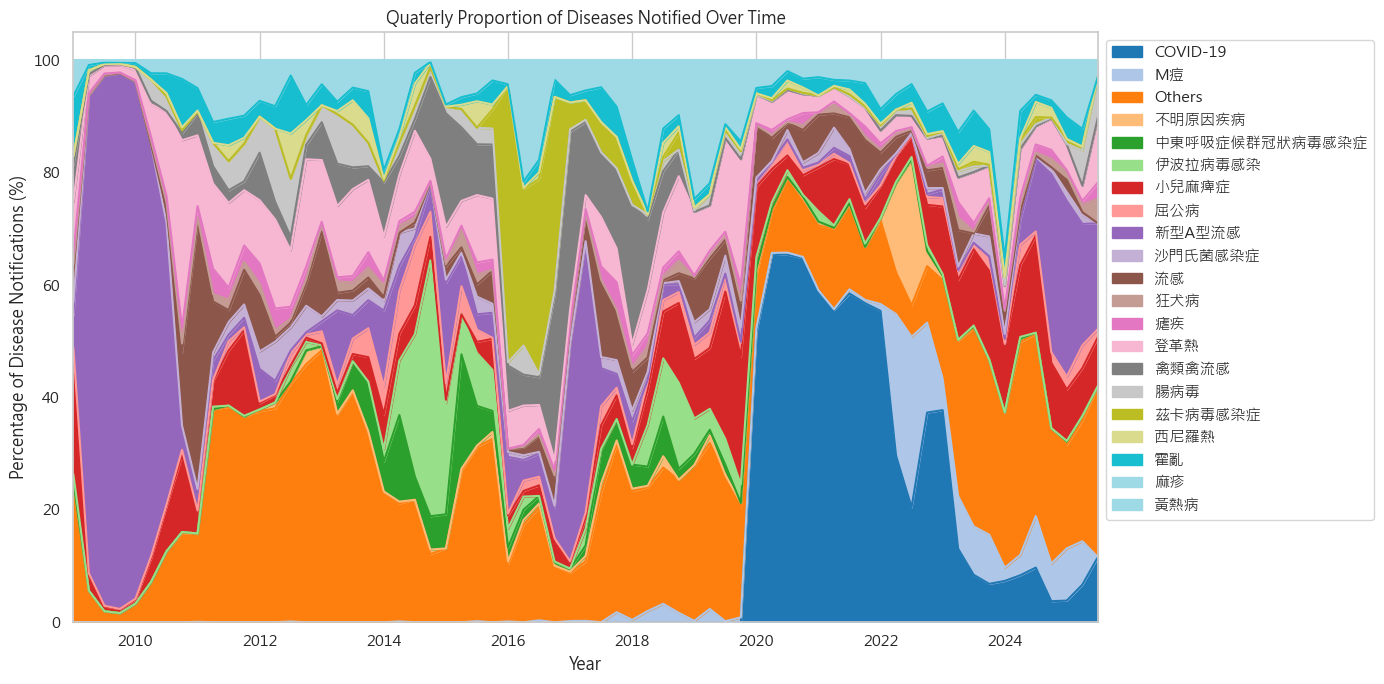

In [97]:
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.family'] = 'Microsoft JhengHei'

plt.rcParams['axes.unicode_minus'] = False

# 🟢 Step 1: Categorize diseases not in list_common_diseases as 'other'
df_plot = df.copy()
df_plot['disease_grouped'] = df_plot['disease_name'].apply(
    lambda x: x if x in list_common_diseases else 'Others'
)

# 🟢 Step 2: Group by month and grouped disease name
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Q'), 'disease_grouped'])# Y Q M
    .size()
    .reset_index(name='count')
)

# Convert Period to Timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# 🟢 Step 3: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='disease_grouped', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# 🟢 Step 4: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Disease Notifications (%)')
plt.title('Quaterly Proportion of Diseases Notified Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Top 5 disease name heatmap

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_94652\352946016.py:51: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



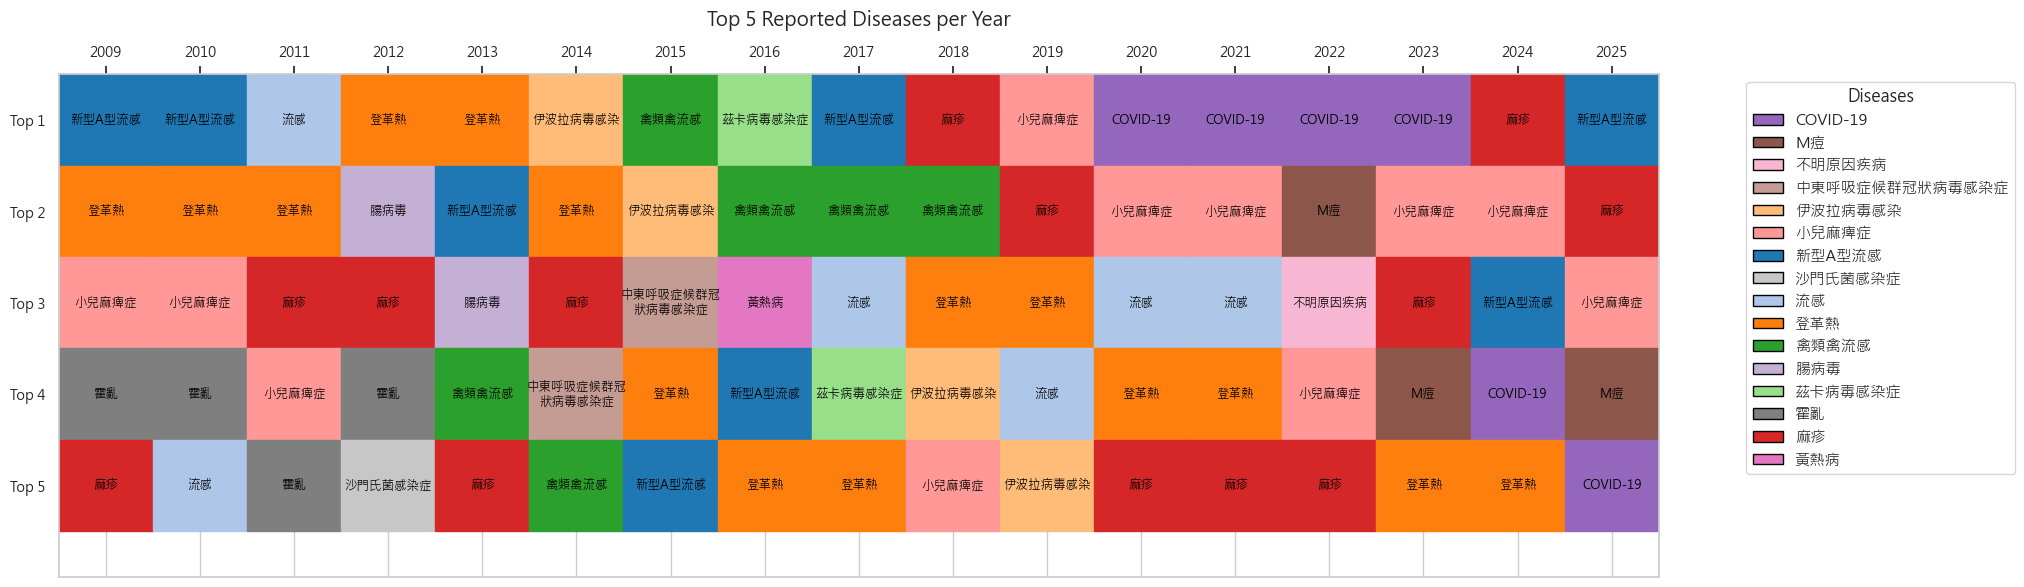

In [98]:
# Top N disease name

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap
# 🟢 Step 1–4: Same as before
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')
df_plot['year'] = df_plot['date'].dt.year

df_counts = (
    df_plot
    .groupby(['year', 'disease_name'])
    .size()
    .reset_index(name='count')
)

top5_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(5)
)

ranked = (
    top5_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['disease_name']
    .apply(list)
    .reset_index()
)
years = ranked['year'].tolist()
disease_table = pd.DataFrame([r + [None] * (5 - len(r)) for r in ranked['disease_name']], index=years).T

# 🟢 Assign unique color
all_diseases = pd.unique(disease_table.values.ravel())
color_map = dict(zip(all_diseases, plt.cm.tab20.colors[:len(all_diseases)]))

# 🟢 Step 5: Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.2, 6))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, 5)


# Draw cells
for col, year in enumerate(years):
    for row in range(5):
        disease = disease_table.iloc[row, col]
        color = color_map.get(disease, 'lightgray')
        ax.add_patch(plt.Rectangle((col, 4 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(disease, width=8)) if disease else ''
        ax.text(col + 0.5, 4 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# 🟢 Step 6: Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')  # move x-axis label to top
ax.xaxis.tick_top()

# 🟢 Step 6.5: Left Y-axis for "Top 1" to "Top 5"
ax.set_yticks([i + 0.5 for i in range(5)])
ax.set_yticklabels([f"Top {i+1}" for i in range(5)][::-1], fontsize=10)

# 🟢 Step 7: Legend
legend_elements = [
    Patch(facecolor=color_map[d], edgecolor='black', label=d)
    for d in sorted(color_map) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title("Top 5 Reported Diseases per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()



### Report histogram

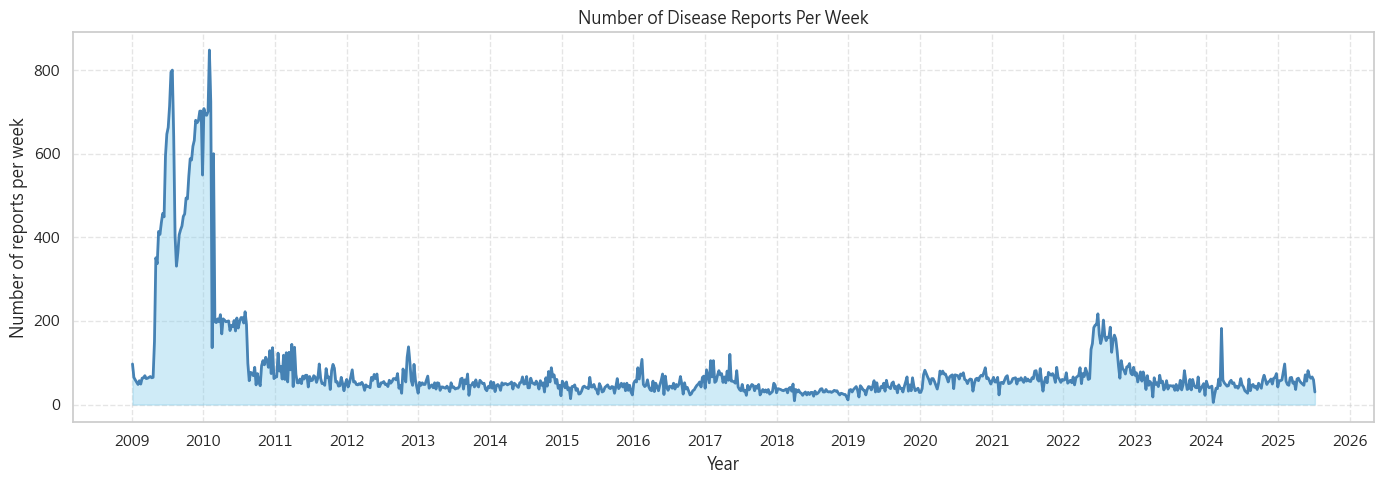

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 🟢 Step 1: Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# 🟢 Step 2: Create a new 'week' column that represents the start of each week
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 3: Group by week and count number of reports per week
df_weekly_counts = df.groupby('week').size().reset_index(name='count')

# 🟢 Step 4: Plot the weekly report count as a bar chart
plt.figure(figsize=(14, 5))
plt.plot(df_weekly_counts['week'], df_weekly_counts['count'], linestyle='-', color='steelblue', linewidth=2)
plt.fill_between(df_weekly_counts['week'], df_weekly_counts['count'], color='skyblue', alpha=0.4)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)
ax.set_yticks([])

plt.title('Number of Disease Reports Per Week')
plt.xlabel('Year')
plt.ylabel('Number of reports per week')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Bubble plot by disease

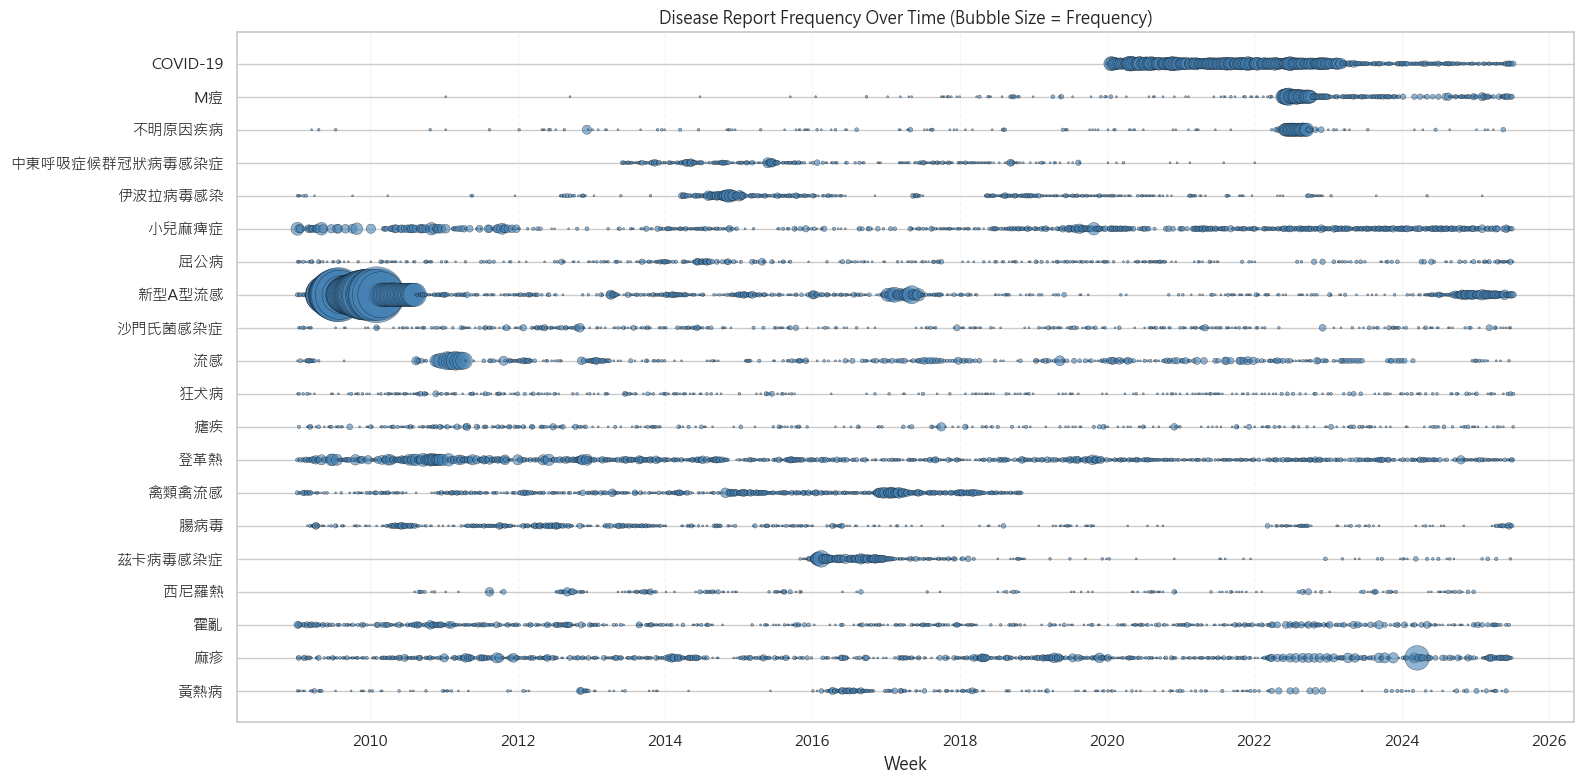

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# 🟢 Step 1: Prepare data
df_plot = df[df['disease_name'].isin(list_common_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# 🟢 Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(16, len(disease_list) * 0.4))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# 🟢 Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show() 


### Bubble plot for PHEIC diseases

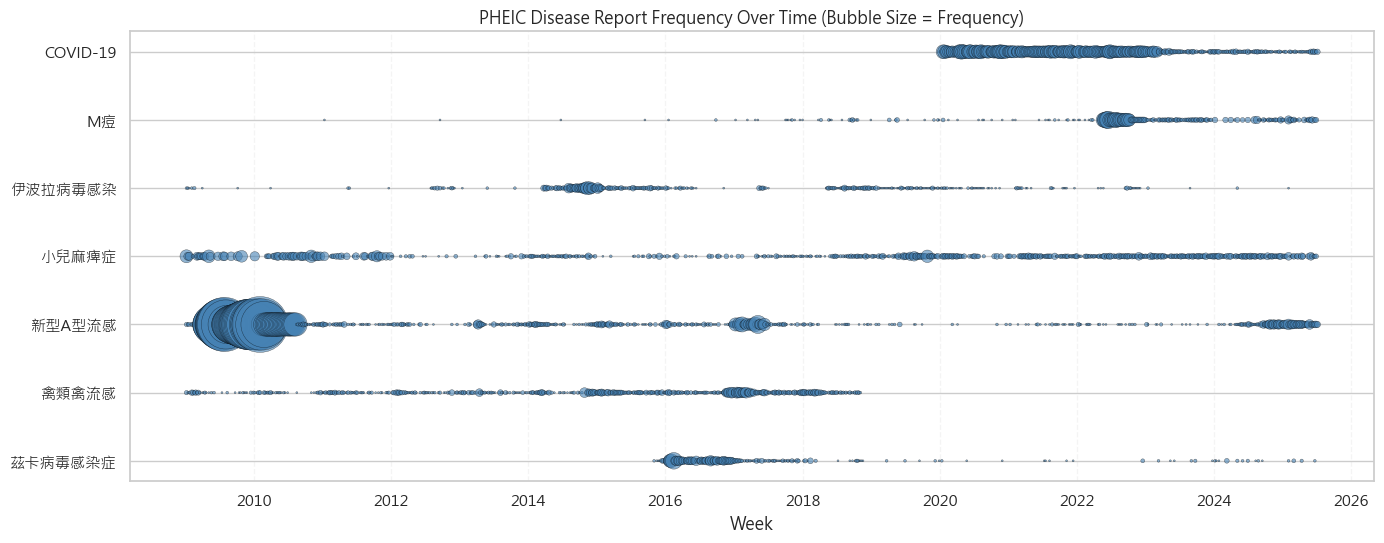

In [197]:
# only PHEIC diseases
import pandas as pd
import matplotlib.pyplot as plt


list_PHEIC_diseases = ["COVID-19","新型A型流感","禽類禽流感","小兒麻痺症","伊波拉病毒感染","M痘","茲卡病毒感染症"]


df_plot = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['week'] = df_plot['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 🟢 Step 2: Count reports per week per disease
df_counts = (
    df_plot
    .groupby(['disease_name', 'week'])
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Assign numeric Y positions
disease_list = sorted(df_counts['disease_name'].unique())
disease_to_y = {d: i for i, d in enumerate(disease_list)}
df_counts['y'] = df_counts['disease_name'].map(disease_to_y)

# 🟢 Step 4: Plot bubble chart
fig, ax = plt.subplots(figsize=(14, len(disease_list) * 0.8))

scatter = ax.scatter(
    df_counts['week'],             # X-axis (time)
    df_counts['y'],                # Y-axis (disease index)
    s=df_counts['count'] * 2,      # Bubble size (tune scale if needed)
    alpha=0.6,
    color='steelblue',
    edgecolors='black',
    linewidth=0.3
)

# 🟢 Step 5: Format axes
ax.set_yticks(range(len(disease_list)))
ax.set_yticklabels(disease_list)
ax.set_xlabel("Week")
ax.set_title("PHEIC Disease Report Frequency Over Time (Bubble Size = Frequency)")
ax.invert_yaxis()  # Optional: most frequent disease at top
ax.grid(True, axis='x', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


## transmission routes


<Figure size 1200x600 with 0 Axes>

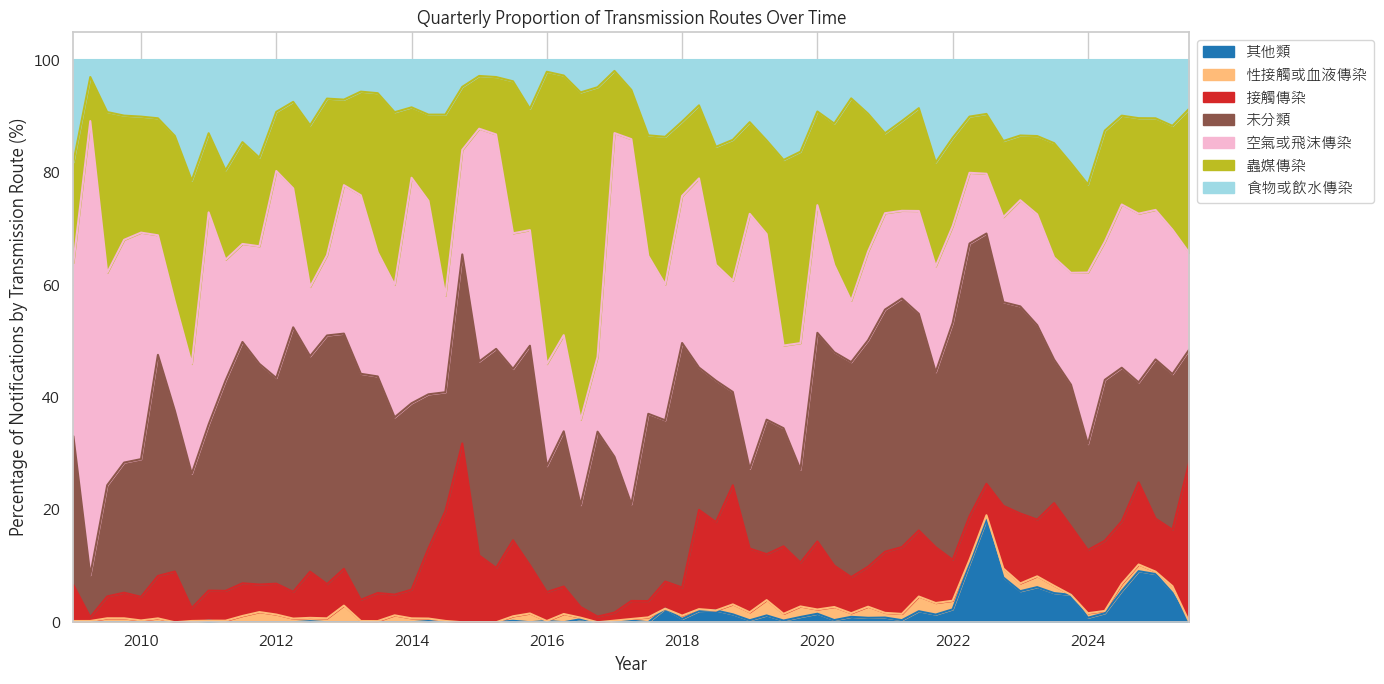

In [102]:
import matplotlib.pyplot as plt
import matplotlib

# 🧾 Font settings for Traditional Chinese
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# 🟢 Step 1: Prepare copy and fill NaNs
df_plot = df_raw.copy()
df_plot['transmission_route'] = df_plot['transmission_route'].fillna('未分類')

# 🟢 Step 2: Extract quarter and group counts by quarter + transmission route
df_plot['date'] = pd.to_datetime(df_plot['date'], errors='coerce')

df_counts = (
    df_plot
    .groupby([df_plot['date'].dt.to_period('Q'), 'transmission_route'])  # quarterly
    .size()
    .reset_index(name='count')
)

# 🟢 Step 3: Convert period to timestamp
df_counts['date'] = df_counts['date'].dt.to_timestamp()

# 🟢 Step 4: Pivot and normalize to percentage
df_pivot = df_counts.pivot(index='date', columns='transmission_route', values='count').fillna(0)
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# 🟢 Step 5: Plot stacked area chart
plt.figure(figsize=(12, 6))
df_percent.plot(kind='area', stacked=True, figsize=(14, 7), colormap='tab20')
plt.ylabel('Percentage of Notifications by Transmission Route (%)')
plt.title('Quarterly Proportion of Transmission Routes Over Time')
plt.xlabel('Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Country visualisations

### Top ten countries

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_94652\2206951059.py:55: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



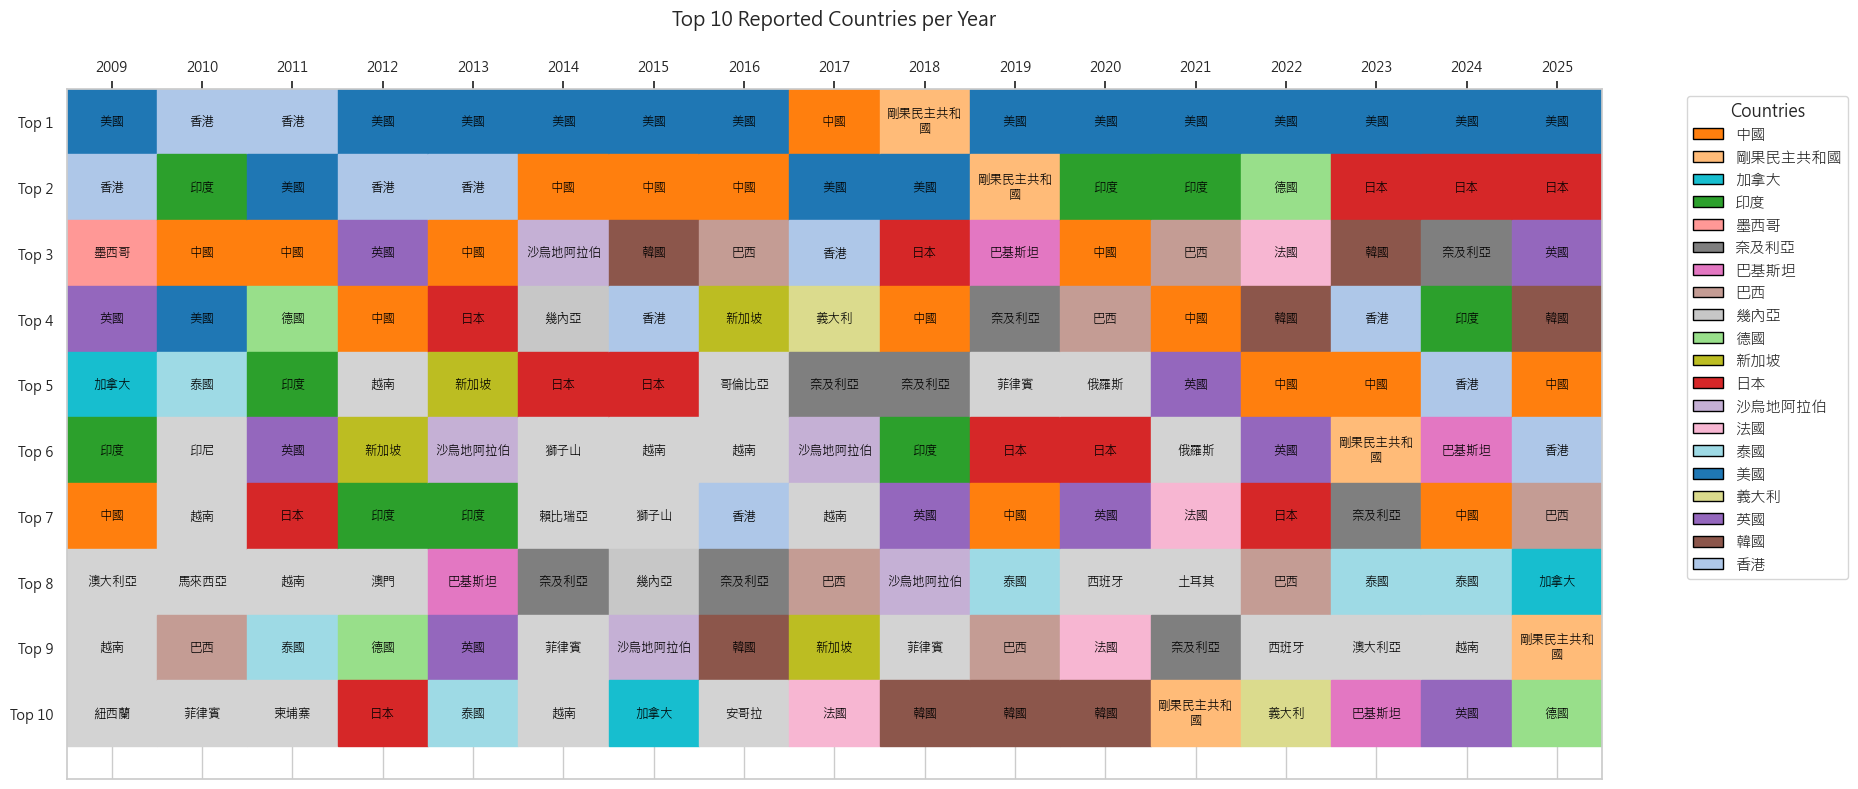

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import textwrap

n_top_countries = 10

# 🟢 Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

df_counts = (
    df_plot
    .groupby(['year', 'country_name_zh'])
    .size()
    .reset_index(name='count')
)

top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# 🟢 Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_name_zh']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_name_zh']],
    index=years
).T

# 🟢 Assign unique colors
all_countries = pd.unique(country_table.values.ravel())
color_map = dict(zip(all_countries, plt.cm.tab20.colors[:len(all_countries)]))

# 🟢 Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country = country_table.iloc[row, col]
        color = color_map.get(country, 'lightgray')
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country, width=6)) if country else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# Legend
legend_elements = [
    Patch(facecolor=color_map[c], edgecolor='black', label=c)
    for c in sorted(color_map) if c is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Countries")

plt.title(f"Top {n_top_countries} Reported Countries per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()

In [105]:
### Top regions

### Top N country_disease

C:\Users\kaitseng\AppData\Local\Temp\1\ipykernel_94652\821595555.py:74: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



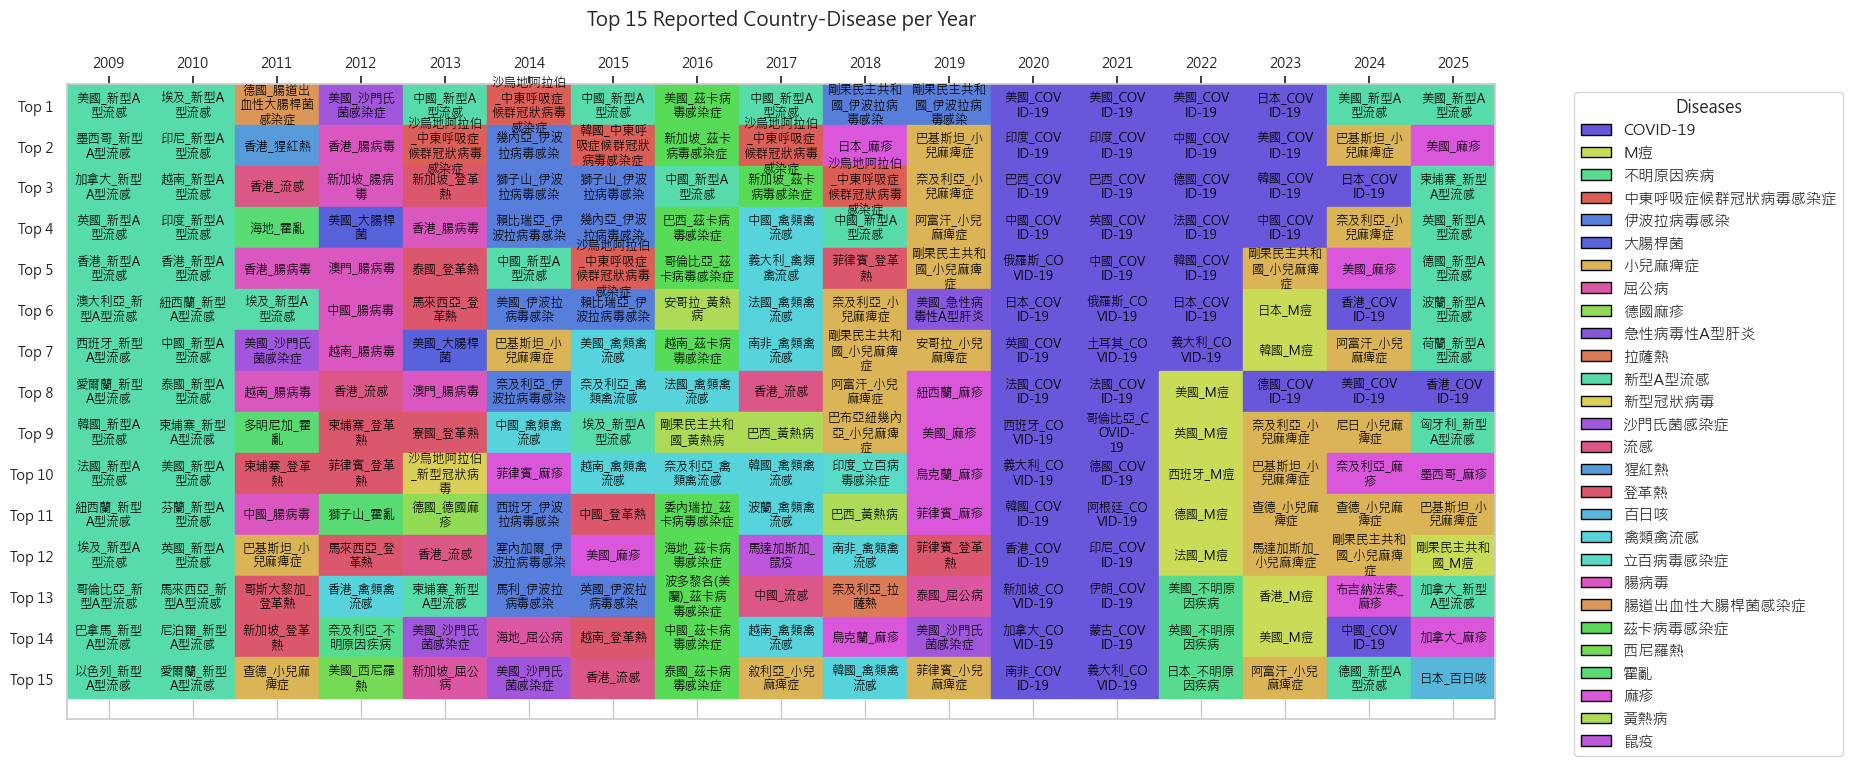

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import textwrap

# 🟢 Parameters
n_top_countries = 15

# 🟢 Prepare data
df_plot = df.copy()
df_plot['year'] = pd.to_datetime(df_plot['date']).dt.year

# Group by year and country_disease, count occurrences
df_counts = (
    df_plot
    .groupby(['year', 'country_disease'])
    .size()
    .reset_index(name='count')
)

# Get top N per year
top_countries_per_year = (
    df_counts
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')
    .head(n_top_countries)
)

# Reshape for plotting
ranked = (
    top_countries_per_year
    .sort_values(['year', 'count'], ascending=[True, False])
    .groupby('year')['country_disease']
    .apply(list)
    .reset_index()
)

years = ranked['year'].tolist()
country_table = pd.DataFrame(
    [r + [None] * (n_top_countries - len(r)) for r in ranked['country_disease']],
    index=years
).T

# 🟢 Extract unique disease names from country_disease strings in top N
diseases_in_top = set()
for col in country_table.columns:
    for val in country_table[col]:
        if val:
            disease = val.split('_')[-1]
            diseases_in_top.add(disease)

# Generate color palette for these diseases
palette = sns.color_palette("hls", len(diseases_in_top))
disease_color_map = dict(zip(diseases_in_top, palette))

# 🟢 Plot
fig, ax = plt.subplots(figsize=(len(years) * 1.1, 8))
ax.set_xlim(0, len(years))
ax.set_ylim(-0.5, n_top_countries)

# Draw cells
for col, year in enumerate(years):
    for row in range(n_top_countries):
        country_disease = country_table.iloc[row, col]
        
        if country_disease:
            # Extract disease_name from country_disease (split by "_")
            disease = country_disease.split('_')[-1]
            color = disease_color_map.get(disease, 'lightgray')
        else:
            color = 'lightgray'
        
        ax.add_patch(plt.Rectangle((col, n_top_countries - 1 - row), 1, 1, color=color, edgecolor='black'))
        wrapped = "\n".join(textwrap.wrap(country_disease, width=6)) if country_disease else ''
        ax.text(col + 0.5, n_top_countries - 1 - row + 0.5, wrapped,
                ha='center', va='center', fontsize=9, color='black')

# Top X-axis for years
ax.set_xticks([i + 0.5 for i in range(len(years))])
ax.set_xticklabels([str(year) for year in years], rotation=0, fontsize=10)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Left Y-axis for rankings
ax.set_yticks([i + 0.5 for i in range(n_top_countries)])
ax.set_yticklabels([f"Top {i+1}" for i in range(n_top_countries)][::-1], fontsize=10)

# 🟢 Legend showing only disease names
legend_elements = [
    Patch(facecolor=disease_color_map[d], edgecolor='black', label=d)
    for d in sorted(diseases_in_top) if d is not None
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Diseases")

plt.title(f"Top {n_top_countries} Reported Country-Disease per Year", fontsize=14, y=1.08)
plt.tight_layout()
plt.show()


# Variety

### 1. Diversity count (baseline)

In [107]:
variety_count = df.groupby(df['date'].dt.year)['country_disease'].nunique().reset_index()
variety_count.columns = ['year', 'unique_country_disease_count']
print(variety_count)


    year  unique_country_disease_count
0   2009                           787
1   2010                          1015
2   2011                          1085
3   2012                           907
4   2013                           714
5   2014                           626
6   2015                           640
7   2016                           630
8   2017                           591
9   2018                           475
10  2019                           603
11  2020                           549
12  2021                           573
13  2022                           729
14  2023                           760
15  2024                           784
16  2025                           511


## 2. Entropy

    year  shannon_entropy
0   2009             5.34
1   2010             5.82
2   2011             6.40
3   2012             6.20
4   2013             5.84
5   2014             5.35
6   2015             5.66
7   2016             5.58
8   2017             4.75
9   2018             5.45
10  2019             5.68
11  2020             4.94
12  2021             4.99
13  2022             5.17
14  2023             5.98
15  2024             6.10
16  2025             5.73


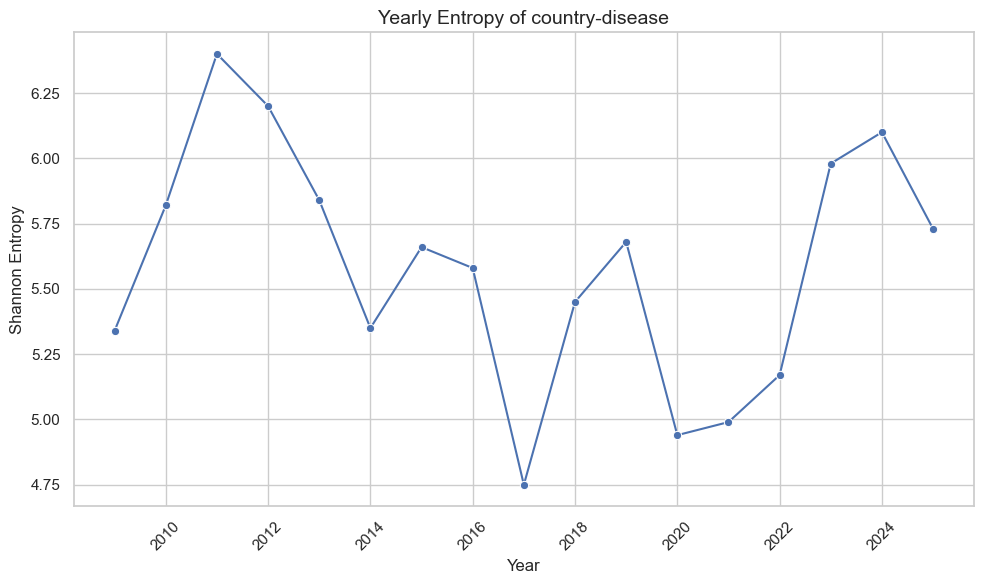

In [108]:
import numpy as np

def shannon_entropy(x):
    counts = x.value_counts()
    proportions = counts / counts.sum()
    return -np.sum(proportions * np.log(proportions))

table_entropy = df.groupby(df['date'].dt.year)['country_disease'].apply(shannon_entropy).reset_index().round(2)
table_entropy.columns = ['year', 'shannon_entropy']
print(table_entropy)


import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your entropy dataframe is available
# entropy = ... (your existing calculation)

# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10,6))
sns.lineplot(data=table_entropy, x='year', y='shannon_entropy', marker='o')

# Titles and labels
plt.title('Yearly Entropy of country-disease', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Shannon Entropy', fontsize=12)

# Optional: rotate x-axis labels if many years
plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

# Timeliness

### Prepare dataset (not conslolidated one "df")
- use df_raw instead of df, which has been expanded by disease and country
- extract end date from description, and get a adjusted source date from SourceTime, SourceTime2, SourceTime_description.
- calculate interval between source date and publish
- calculate median value by year and assess missingness

In [109]:
# (1) extract date from source ###
def extract_source_time_source(row):
    source = row['Source']
    date_row = pd.to_datetime(row['date'], errors='coerce')
    year = date_row.year if pd.notna(date_row) else None

    if pd.isna(source) or year is None:
        return pd.NaT

    # Regex to find dates like "9/20" or "8/2"
    matches = re.findall(r'(\d{1,2})/(\d{1,2})', source)
    
    most_recent_date = pd.NaT

    for month_str, day_str in matches:
        month = int(month_str)
        day = int(day_str)
        try:
            date_obj = pd.Timestamp(year=year, month=month, day=day)
            
            # Skip if date_obj is after the reference date
            if date_obj > date_row:
                continue

            # Update if more recent
            if pd.isna(most_recent_date) or date_obj > most_recent_date:
                most_recent_date = date_obj

        except ValueError:
            continue  # Skip invalid dates

    return most_recent_date


df_raw['SourceTime_source'] = df_raw.apply(extract_source_time_source, axis=1)


# (2) extract the source date from the description ### 
def extract_source_time(row):
    # Only extract if both SourceTime and SourceTime2 are missing
    if pd.notna(row['SourceTime']) or pd.notna(row['SourceTime2']):
        return pd.NaT

    description = row['description']
    date_row = pd.to_datetime(row['date'], errors='coerce')
    year = pd.to_datetime(row['date'], errors='coerce').year

    if pd.isna(description):
        return pd.NaT

    # Find all patterns like "截至今年12/8" or "截至12/8" or "今年截至12/8" or "截至6月25日" or "截至今年6月25日"
    matches = re.findall(r'截至(?:今年)?(\d{1,2})[月/](\d{1,2})日?', description)
    
    if matches:
        dates = []
        for month_str, day_str in matches:
            month = int(month_str)
            day = int(day_str)
            try:
                date_obj = pd.Timestamp(year=year, month=month, day=day)
                dates.append(date_obj)
            except ValueError:
                continue  # skip invalid dates

        if dates:
            max_date = max(dates)
            if max_date > date_row:  # If max_date is later than date_row, treat as missing
                return pd.NaT
            else:
                return max_date    
    return pd.NaT

df_raw['SourceTime_description'] = df_raw.apply(extract_source_time, axis=1)

# (3) Get adjusted source date ###
def calculate_adjusted_source_time(row):
    t1 = row['SourceTime']
    t2 = row['SourceTime2']
    t3 = row['SourceTime_description'] 
    t4 = row['SourceTime_source']
    if pd.notna(t1) and pd.notna(t2):
        # initially I tried to look the median of t1 t2, which looks bad in 2020-2024, so now I only choose the most recent source date
        # delta_days = (t2 - t1).days
        # half_days_ceil = int(np.ceil(delta_days / 2)) #round up to an integer number of days (無條件進位)
        # return t1 + pd.Timedelta(days=half_days_ceil)
        return t2
    elif pd.notna(t2):
        return t2
    elif pd.notna(t1):
        return t1
    elif pd.notna(t3):
        return t3
    elif pd.notna(t4):
        return t4
    else:
        return pd.NaT # Both missing

df_raw['SourceTime_adj'] = df_raw.apply(calculate_adjusted_source_time, axis=1)

# (4) calculate interval between publish date and median source date ###
def calculate_interval_source_publish(row):
    date_source = pd.to_datetime(row['SourceTime_adj'], errors='coerce')
    date_publish = pd.to_datetime(row['date'], errors='coerce')
    if pd.notna(date_source) and pd.notna(date_publish):
        delta_days = (date_publish - date_source).days
        return delta_days
    else:
        return pd.NaT 

df_raw['interval_source_publish'] = df_raw.apply(calculate_interval_source_publish, axis=1)
df_raw['year'] = pd.to_datetime(df_raw['date']).dt.year

# (5) Group by year and aggregate ###
table_timeliness_byyear = (
    df_raw.groupby('year')
    .agg(
        median_interval=('interval_source_publish', 'median'),
        mean_interval=('interval_source_publish', 'mean'),
        missing_percent=('SourceTime_adj', lambda x: x.isna().mean().round(3) * 100) )# equals to "interval_source_publish"
    .reset_index())

print(table_timeliness_byyear)

# df_raw_source_date_missing = df_raw[df_raw['interval_source_publish'].isna()]
# df_raw_source_date_missing.to_csv('interval_source_publish_missing.csv', index=True)

    year median_interval mean_interval  missing_percent
0   2009             1.0          3.53             10.6
1   2010             1.0      2.269499              3.6
2   2011             1.0      2.234707              2.8
3   2012             2.0      3.028528              1.0
4   2013             3.0      3.611853              1.0
5   2014             3.0      3.255881              0.9
6   2015             2.0      2.454362              0.3
7   2016             2.0      2.887037              0.1
8   2017             3.0     23.609732              0.1
9   2018             3.0      3.836379              0.4
10  2019             3.0      3.574383              0.6
11  2020             2.0      2.524469              0.3
12  2021             2.0      2.057014              0.1
13  2022             2.0      4.063111              1.2
14  2023             6.0      7.273143              3.0
15  2024             7.0      9.344645              4.2
16  2025             4.0      6.163743          

### Plot the median of interval source-publish

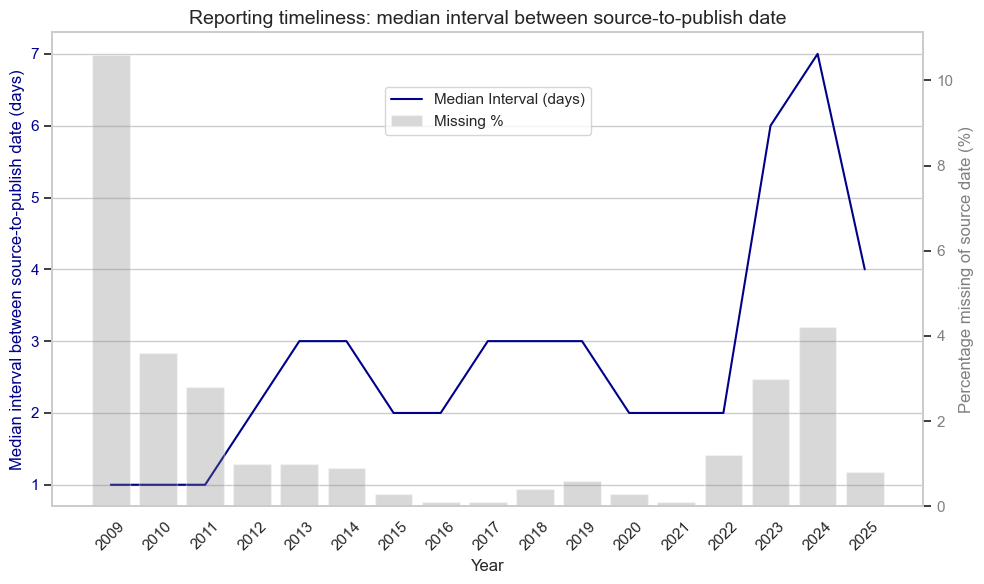

In [110]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot median interval (line) on left y-axis
ax1.plot(table_timeliness_byyear['year'], table_timeliness_byyear['median_interval'],
         color='darkblue', label='Median Interval (days)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Median interval between source-to-publish date (days)', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Set x-axis to integer years
ax1.set_xticks(table_timeliness_byyear['year'])
ax1.set_xticklabels(table_timeliness_byyear['year'].astype(int), rotation=45)
ax1.grid(axis='x', visible=False)
ax1.grid(axis='y', visible=True)

# Create right y-axis for missing percentage
ax2 = ax1.twinx()
ax2.bar(table_timeliness_byyear['year'], table_timeliness_byyear['missing_percent'],
        alpha=0.3, color='grey', label='Missing %')
ax2.set_ylabel('Percentage missing of source date (%)', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
ax2.grid(axis='y', visible=False)

# 🔧 Titles and layout
plt.title('Reporting timeliness: median interval between source-to-publish date', fontsize=14)
fig.tight_layout()

# 🔧 Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 0.9))

plt.show()

# Sanky plot: data sources, country, disease, transmission routs

In [111]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc

# Step 1: Prepare data
df['date'] = pd.to_datetime(df['date'])

df_temp = df[df['date'].dt.year > 2020]# subsetting 2009, 2020

df_temp = df_temp[['country_name_zh', 'disease_name']]


# Step 2: Keep top 5 countries and diseases, group others
top_countries = df_temp['country_name_zh'].value_counts().nlargest(10).index
top_diseases = df_temp['disease_name'].value_counts().nlargest(10).index
print(top_countries)
df_temp['country_name_zh_sanky'] = df_temp['country_name_zh'].where(df_temp['country_name_zh'].isin(top_countries), '其他國家')
df_temp['disease_name_sanky'] = df_temp['disease_name'].where(df_temp['disease_name'].isin(top_diseases), '其他疾病')

# Step 3: Group and filter
df_grouped = df_temp.groupby(['country_name_zh_sanky', 'disease_name_sanky']).size().reset_index(name='count')
df_grouped = df_grouped[df_grouped['count'] >= 100]# to make the graph less busy

# Step 4: Build node list and index
all_nodes = pd.Series(df_grouped['country_name_zh_sanky'].tolist() + df_grouped['disease_name_sanky'].tolist()).unique()
node_indices = {name: i for i, name in enumerate(all_nodes)}
df_grouped['source'] = df_grouped['country_name_zh_sanky'].map(node_indices)
df_grouped['target'] = df_grouped['disease_name_sanky'].map(node_indices)

# Step 5: Assign reasonable node colors
# Use pastel Set3 for visual harmony (enough contrast, easy on eyes)
# color_palette = pc.qualitative.Set3
# node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]
color_palette = pc.qualitative.Bold  # High-contrast, vivid
node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]


# Step 6: Assign link colors based on target (disease node)
target_colors = {name: node_colors[node_indices[name]] for name in df_grouped['disease_name_sanky'].unique()}
df_grouped['link_color'] = df_grouped['disease_name_sanky'].map(target_colors)

# Step 7: Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_grouped['source'],
        target=df_grouped['target'],
        value=df_grouped['count'],
        color=df_grouped['link_color']  # match disease color
    )
)])

fig.update_layout(
    width=800,
    height=900,
    title_text="Sankey Diagram: Countries to Diseases, 2020-2025",
    font_size=12
)
fig.show()




Index(['美國', '中國', '日本', '巴西', '英國', '韓國', '德國', '法國', '印度', '奈及利亞'], dtype='object', name='country_name_zh')


### Sanky: country-disease-route

In [112]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc

# === Step 1: Prepare and clean data ===
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_temp = df[df['date'].dt.year > 2020][['WHO_region', 'country_name_zh', 'disease_name', 'transmission_route']]

# === Step 2: Keep top N countries and diseases for clarity ===
top_countries = df_temp['country_name_zh'].value_counts().nlargest(15).index
top_diseases = df_temp['disease_name'].value_counts().nlargest(15).index

df_temp['country_grouped'] = df_temp['country_name_zh'].where(df_temp['country_name_zh'].isin(top_countries), '其它國家')
df_temp['disease_grouped'] = df_temp['disease_name'].where(df_temp['disease_name'].isin(top_diseases), '其它疾病')
df_temp['route_grouped'] = df_temp['transmission_route'].fillna('Unknown')
df_temp['region_grouped'] = df_temp['WHO_region'].fillna('Other')

# === Step 3: Create three sets of links ===
link0 = (
    df_temp.groupby(['region_grouped', 'country_grouped'])
    .size()
    .reset_index(name='count')
)

link1 = (
    df_temp.groupby(['country_grouped', 'disease_grouped'])
    .size()
    .reset_index(name='count')
)

link2 = (
    df_temp.groupby(['disease_grouped', 'route_grouped'])
    .size()
    .reset_index(name='count')
)

# === Step 4: Filter small links to reduce clutter ===
link0 = link0[link0['count'] >= 50]
link1 = link1[link1['count'] >= 50]
link2 = link2[link2['count'] >= 50]

# === Step 5: Build unique node list and index mapping ===
all_nodes = pd.Series(
    link0['region_grouped'].tolist() +
    link0['country_grouped'].tolist() +
    link1['disease_grouped'].tolist() +
    link2['route_grouped'].tolist()
).unique()

node_indices = {name: i for i, name in enumerate(all_nodes)}

# Map source and target indices
link0['source'] = link0['region_grouped'].map(node_indices)
link0['target'] = link0['country_grouped'].map(node_indices)

link1['source'] = link1['country_grouped'].map(node_indices)
link1['target'] = link1['disease_grouped'].map(node_indices)

link2['source'] = link2['disease_grouped'].map(node_indices)
link2['target'] = link2['route_grouped'].map(node_indices)

# === Step 6: Assign colors to nodes ===
color_palette = pc.qualitative.Bold
node_colors = [color_palette[i % len(color_palette)] for i in range(len(all_nodes))]

# Color by disease and route for links
disease_color_map = {name: node_colors[node_indices[name]] for name in link1['disease_grouped'].unique()}
route_color_map = {name: node_colors[node_indices[name]] for name in link2['route_grouped'].unique()}

link0['color'] = link0['country_grouped'].map(lambda x: node_colors[node_indices.get(x, 0)])
link1['color'] = link1['disease_grouped'].map(disease_color_map)
link2['color'] = link2['route_grouped'].map(route_color_map)

# === Step 7: Combine all links ===
df_links = pd.concat([
    link0[['source', 'target', 'count', 'color']],
    link1[['source', 'target', 'count', 'color']],
    link2[['source', 'target', 'count', 'color']]
], ignore_index=True)

# === Step 8: Plot Sankey Diagram ===
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors
    ),
    link=dict(
        source=df_links['source'],
        target=df_links['target'],
        value=df_links['count'],
        color=df_links['color']
    )
)])


fig.update_layout(
    font=dict(size=14, color='black', family="Arial"),
    title_text="Sankey Diagram: WHO Region → Country → Disease → Transmission Route (2020–2025)",
    width=1100,
    height=950
)

fig.show()



# Table 1 - overview table

In [195]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.isocalendar().year
df['week_number'] = df['date'].dt.isocalendar().week

# 平均每週標題數
weekly_headline_counts = df.groupby(['year', 'week_number'])['description'].nunique().reset_index(name='平均每週標題數') # assuming description is valid as headline+date
mean_weekly_headline_counts = weekly_headline_counts.groupby('year')['平均每週標題數'].mean().round().astype(int).reset_index()

# 平均每週國家疾病數
weekly_country_disease_counts = df.groupby(['year', 'week_number']).size().reset_index(name='平均每週國家疾病數')
mean_weekly_country_disease_counts = weekly_country_disease_counts.groupby('year')['平均每週國家疾病數'].mean().round(0).astype(int).reset_index()

# 當年國家總數(非重複)
annual_country_counts = df.groupby(['year'])['country_name_en'].nunique().reset_index(name = '年度國家總數(非重複)')# iso3 can be missing?

# 當年疾病總數(非重複)
annual_disease_counts = df.groupby(['year'])['disease_name'].nunique().reset_index(name = '年度疾病總數(非重複)')

# 當年國家疾病總數(非重複)
annual_country_disease_counts = df.groupby(['year'])['country_disease'].nunique().reset_index(name = '年度國家疾病總數(非重複)')

# 時效性
table_timeliness_byyear_median = table_timeliness_byyear[["year","median_interval"]].round().astype(int).rename(
    columns={"median_interval": "中位數時效性"} )

# 內容字數
df_raw['description_lengths'] = df_raw['description'].str.len()
word_counts_by_year = df_raw.groupby('year')['description_lengths'].mean().round().astype(int).reset_index(name = '平均報導字數')


# entropy
table_entropy = table_entropy.round(1).rename(columns={'shannon_entropy': '國家疾病熵值'})

# 當年資料來源數量(非重複)
temp_source_exploded = df_raw.explode('Source_list')# explode the list
unique_sources_count_by_year = (
    temp_source_exploded.groupby('year')['Source_list']
    .nunique()
    .reset_index()
    .rename(columns={'Source_list': '資料來源數(不重複)'}) )



# 傳染途徑 
table_transmission_counts = df.groupby(['year', 'transmission_route']).size().reset_index(name='count')
table_transmission_counts['percentage'] = (
    table_transmission_counts['count'] / table_transmission_counts.groupby('year')['count'].transform('sum') * 100
)

route_ordered_columns = ['空氣或飛沫傳染', '接觸傳染','食物或飲水傳染','蟲媒傳染','性接觸或血液傳染','其他']
pivot_table_transmission_route = table_transmission_counts.pivot_table(
    index='year', 
    columns='transmission_route',
    values='percentage',
    fill_value=0)

ordered_columns = [col for col in route_ordered_columns if col in pivot_table_transmission_route.columns]
pivot_table_transmission_route = pivot_table_transmission_route[ordered_columns]

pivot_table_transmission_route['proportion_transmission_route'] = pivot_table_transmission_route[ordered_columns].apply(
    lambda row: ', '.join(str(int(round(val))) for val in row),
    axis=1
)

pivot_table_transmission_route = pivot_table_transmission_route.reset_index()[['year', 'proportion_transmission_route']].rename(columns={'proportion_transmission_route': '感染來源百分比'})
#print(pivot_table_transmission_route)




# merging master table 
summary_table_1 = pd.merge(mean_weekly_headline_counts, mean_weekly_country_disease_counts,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_country_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_disease_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, annual_country_disease_counts, 
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_timeliness_byyear_median, #from Timeliness section
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, table_entropy,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, word_counts_by_year,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, unique_sources_count_by_year,
                           on='year', how='outer')
summary_table_1 = pd.merge(summary_table_1, pivot_table_transmission_route,
                           on='year', how='outer')
# Display the result
print(summary_table_1)

    year  平均每週標題數  平均每週國家疾病數  年度國家總數(非重複)  年度疾病總數(非重複)  年度國家疾病總數(非重複)  中位數時效性  \
0   2009       37        392          205           85            787       1   
1   2010       31        221          203          110           1015       1   
2   2011       30         70          194          127           1085       1   
3   2012       36         58          179          130            907       2   
4   2013       35         46          136          135            710       3   
5   2014       32         51          152          119            625       3   
6   2015       28         40          146          111            640       2   
7   2016       31         48          174           86            630       2   
8   2017       28         51          153           97            591       3   
9   2018       23         30          137           79            475       3   
10  2019       24         40          152          113            601       3   
11  2020       21         61

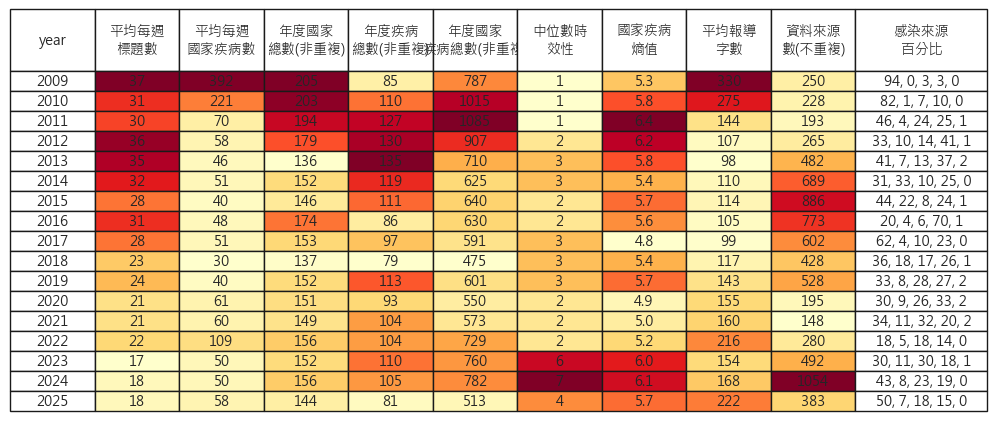

In [196]:
# heat map table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['font.family'] = 'Microsoft JhengHei' # Ensuring Mandarin layouts

summary_table_1.columns = [
    col if len(col) <= 4 else col[:4] + '\n' + col[4:]
    for col in summary_table_1.columns
]


# Initialize cell colors
cell_colors = np.full((summary_table_1.shape[0], summary_table_1.shape[1]), 'white', dtype=object)

# Apply per-column normalization for numeric columns (skip 'year')
for col_idx in range(1, summary_table_1.shape[1] -1 ): # -1 remove transmission routes
    col_values = summary_table_1.iloc[:, col_idx]
    norm = plt.Normalize(col_values.min(), col_values.max())  # Normalize per column
    for row_idx in range(summary_table_1.shape[0]):
        cell_colors[row_idx, col_idx] = plt.cm.YlOrRd(norm(col_values.iloc[row_idx]))

# Create table plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

table = ax.table(
    cellText=summary_table_1.values,
    colLabels=summary_table_1.columns,
    cellLoc='center',
    loc='center',
    cellColours=cell_colors
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# expand first row space
for (row, col), cell in table.get_celld().items():
    if row == 0:  # 表頭 row
        cell.set_height(0.2) 


for (row, col), cell in table.get_celld().items():
    if col == 10: # column index
        cell.set_width(0.17) # column wider 

plt.show()

# Graph 4: PHEIC summary
For each disease, mark the frist CDC-report date,  PHEIC announance date, PHEIC end date, research end date

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# (1) PHEIC timing 
table_PHEIC_timeline = pd.DataFrame({
    'PHEIC_name': [
        'H5N1流感',
        '小兒麻痺症',
        '伊波拉病毒感染(西非)',
        '茲卡病毒感染症',
        '伊波拉病毒感染(剛果民主共和國)',
        'COVID-19',
        'M痘(II型)',
        'M痘(Ib型)'],
    'disease_name': [
        '新型A型流感/禽類禽流感',
        '小兒麻痺症',
        '伊波拉病毒感染',
        '茲卡病毒感染症',
        '伊波拉病毒感染',
        'COVID-19',
        'M痘',
        'M痘'],
    'date_PHEIC_start': [ #references
        '2009-04-25', # https://www.who.int/groups/h1n1-ihr-emergency-committee
        '2014-05-05', # https://polioeradication.org/public-health-emergency-status/
        '2014-08-08', # https://news.un.org/en/story/2014/08/474732#:~:text=Based%20on%20the%20advice%20of%20the%20Executive%20Committee%2C,a%20Public%20Health%20Emergency%20of%20International%20Concern%20%28PHEIC%29.%E2%80%9D
        '2016-02-01', # https://www.ecdc.europa.eu/en/news-events/who-ends-zika-public-health-emergency-international-concern#:~:text=The%20Director-General%20of%20World%20Health%20Organization%20%28WHO%29%2C%20on,neurological%20disorders%20and%20Zika%20virus%20on%2018%20November.
        '2019-07-17', # https://www.who.int/news/item/17-07-2019-ebola-outbreak-in-the-democratic-republic-of-the-congo-declared-a-public-health-emergency-of-international-concern
        '2020-01-30', # https://www.who.int/publications/m/item/covid-19-public-health-emergency-of-international-concern-%28pheic%29-global-research-and-innovation-forum
        '2022-07-23', # https://www.who.int/groups/monkeypox-ihr-emergency-committee#:~:text=On%2023%20July%202022%2C%20the%20WHO%20Director-General%20determined,and%20issued%20Temporary%20Recommendations%20to%20States%20Parties%20accordingly.
        '2024-08-14'],# https://www.who.int/news/item/19-08-2024-first-meeting-of-the-international-health-regulations-(2005)-emergency-committee-regarding-the-upsurge-of-mpox-2024#:~:text=The%20Director-General%20of%20the%20World%20Health%20Organization%20%28WHO%29%2C,concern%20%28PHEIC%29%20under%20the%20provisions%20of%20the%20Regulations. 
    'date_PHEIC_end': [
        '2010-08-10', # https://www.who.int/news/item/10-08-2010-director-general-statement-following-the-ninth-meeting-of-the-emergency-committee
        None,
        '2016-03-29', # https://www.who.int/news/item/29-03-2016-statement-on-the-9th-meeting-of-the-ihr-emergency-committee-regarding-the-ebola-outbreak-in-west-africa
        '2016-11-18', # https://www.ecdc.europa.eu/en/news-events/who-ends-zika-public-health-emergency-international-concern#:~:text=The%20Director-General%20of%20World%20Health%20Organization%20%28WHO%29%2C%20on,neurological%20disorders%20and%20Zika%20virus%20on%2018%20November.
        '2020-06-25', # https://www.who.int/news/item/25-06-2020-10th-ebola-outbreak-in-the-democratic-republic-of-the-congo-declared-over-vigilance-against-flare-ups-and-support-for-survivors-must-continue
        '2023-05-05', # https://www.who.int/news/item/05-05-2023-statement-on-the-fifteenth-meeting-of-the-international-health-regulations-%282005%29-emergency-committee-regarding-the-coronavirus-disease-%28covid-19%29-pandemic
        '2023-05-11', # https://www.paho.org/en/news/11-5-2023-who-declares-end-mpox-emergency-calls-sustained-efforts-long-term-management-disease#:~:text=May%2011%2C%202023-%20The%20Emergency%20Committee%20on%20monkeypox,Concern%20%28PHEIC%29%2C%20given%20the%20sustained%20decline%20in%20cases.
        None],
    'date_study_end' : [research_end_date] * 8
})

#print(table_PHEIC_timeline)

# (2) clean PHEIC subset and get the earlist reporting date
list_PHEIC_diseases = ["COVID-19","新型A型流感","禽類禽流感","小兒麻痺症","伊波拉病毒感染","M痘","茲卡病毒感染症"]


df_PHEIC = df[df['disease_name'].isin(list_PHEIC_diseases)].copy()
df_PHEIC = df_PHEIC[['disease_name','date',"country_name_zh","country_iso3","description"]]
df_PHEIC.loc[df_PHEIC['disease_name'].isin(['新型A型流感', '禽類禽流感']), 'disease_name'
             ] = '新型A型流感/禽類禽流感'

df_PHEIC['date'] = pd.to_datetime(df_plot['date'])
df_PHEIC = df_PHEIC.sort_values(by='date')
df_PHEIC_earliest = df_PHEIC.groupby('disease_name').first().reset_index().rename(columns={'date': 'date_CDC_initial_alert'})

# (3) merge earlist reporting date to timeline
table_PHEIC_timeline = pd.merge(
    table_PHEIC_timeline,
    df_PHEIC_earliest[['disease_name','date_CDC_initial_alert','description']],
    on='disease_name',
    how='left')

# !!!!! pending: for ebola and mpox, I define that after one year of PHEIC termination, we can reset for the next PHEIC alert
table_PHEIC_timeline.loc[table_PHEIC_timeline['PHEIC_name'] == '伊波拉病毒感染(剛果民主共和國)', 'date_CDC_initial_alert'] = '2017-03-29' # one year post 2016-03-29
table_PHEIC_timeline.loc[table_PHEIC_timeline['PHEIC_name'] == 'M痘(Ib型)', 'date_CDC_initial_alert'] = '2024-05-10' # one yaer post 2023-05-11

print(table_PHEIC_timeline)

# date formatting
for col in ['date_CDC_initial_alert', 'date_PHEIC_start', 'date_PHEIC_end', 'date_study_end']:
    table_PHEIC_timeline[col] = pd.to_datetime(table_PHEIC_timeline[col])

df_PHEIC['date'] = pd.to_datetime(df_PHEIC['date'])


# table_PHEIC_timeline2.to_excel("data/testPHEIC.xlsx", index=False)

         PHEIC_name  disease_name date_PHEIC_start date_PHEIC_end  \
0            H5N1流感  新型A型流感/禽類禽流感       2009-04-25     2010-08-10   
1             小兒麻痺症         小兒麻痺症       2014-05-05           None   
2       伊波拉病毒感染(西非)       伊波拉病毒感染       2014-08-08     2016-03-29   
3           茲卡病毒感染症       茲卡病毒感染症       2016-02-01     2016-11-18   
4  伊波拉病毒感染(剛果民主共和國)       伊波拉病毒感染       2019-07-17     2020-06-25   
5          COVID-19      COVID-19       2020-01-30     2023-05-05   
6           M痘(II型)            M痘       2022-07-23     2023-05-11   
7           M痘(Ib型)            M痘       2024-08-14           None   

  date_study_end date_CDC_initial_alert  \
0     2025-07-09             2009-01-05   
1     2025-07-09             2009-01-06   
2     2025-07-09             2009-01-05   
3     2025-07-09             2015-11-02   
4     2025-07-09             2017-03-29   
5     2025-07-09             2020-01-02   
6     2025-07-09             2011-01-14   
7     2025-07-09             2024-

### summary table

In [249]:
# PHEIC phases before, ongoing, after, summary statistics
research_end_date = pd.to_datetime(research_end_date)

def calculate_pheic_metrics(row):
    disease = row['disease_name']
    alert = row['date_CDC_initial_alert']
    start = row['date_PHEIC_start']
    end = row['date_PHEIC_end']
    if pd.isnull(end):
        end = research_end_date

    # Subset df_PHEIC
    subset = df_PHEIC[df_PHEIC['disease_name'] == disease].copy()
    subset['date'] = pd.to_datetime(subset['date'])

    # 1. Interval between alert and start
    interval_alert_to_start = (start - alert).days if pd.notnull(alert) and pd.notnull(start) else None

    # 2. Average obs between alert and start (weekly)
    between_alert_start = subset[(subset['date'] >= alert) & (subset['date'] < start)]
    days_alert_to_start = max((start - alert).days / 7 , 1)
    obs_alert_to_start = len(between_alert_start) / days_alert_to_start if days_alert_to_start > 0 else None

    # 3. Average obs between start and end (weekly)
    between_start_end = subset[(subset['date'] >= start) & (subset['date'] < end)]
    days_start_to_end = max((end - start).days / 7, 1)
    obs_start_to_end = len(between_start_end) / days_start_to_end if days_start_to_end > 0 else None

    # 4. Average obs between end and study end (weekly)
    between_end_study = subset[(subset['date'] >= end) & (subset['date'] <= research_end_date)]
    days_end_to_study = max((research_end_date - end).days / 7, 1)
    obs_end_to_study = len(between_end_study) / days_end_to_study if days_end_to_study > 0 else None

    return pd.Series({
        'interval_days_alert_to_start': interval_alert_to_start,
        'avg_weekly_obs_alert_to_start': round(obs_alert_to_start, 2) if obs_alert_to_start is not None else None,
        'avg_weekly_obs_start_to_end': round(obs_start_to_end, 2) if obs_start_to_end is not None else None,
        'avg_weekly_obs_end_to_study': round(obs_end_to_study, 2) if obs_end_to_study is not None else None
    })

# ✅ Apply and merge
metrics_PHEIC = table_PHEIC_timeline.apply(calculate_pheic_metrics, axis=1)
table_PHEIC_summary = pd.concat([table_PHEIC_timeline, metrics_PHEIC], axis=1)

print(table_PHEIC_summary)

         PHEIC_name  disease_name date_PHEIC_start date_PHEIC_end  \
0            H5N1流感  新型A型流感/禽類禽流感       2009-04-25     2010-08-10   
1             小兒麻痺症         小兒麻痺症       2014-05-05            NaT   
2       伊波拉病毒感染(西非)       伊波拉病毒感染       2014-08-08     2016-03-29   
3           茲卡病毒感染症       茲卡病毒感染症       2016-02-01     2016-11-18   
4  伊波拉病毒感染(剛果民主共和國)       伊波拉病毒感染       2019-07-17     2020-06-25   
5          COVID-19      COVID-19       2020-01-30     2023-05-05   
6           M痘(II型)            M痘       2022-07-23     2023-05-11   
7           M痘(Ib型)            M痘       2024-08-14            NaT   

  date_study_end date_CDC_initial_alert  \
0     2025-07-09             2009-01-05   
1     2025-07-09             2009-01-06   
2     2025-07-09             2009-01-05   
3     2025-07-09             2015-11-02   
4     2025-07-09             2017-03-29   
5     2025-07-09             2020-01-02   
6     2025-07-09             2011-01-14   
7     2025-07-09             2024-

### Visualisation

c:\Users\kaitseng\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\themes\themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


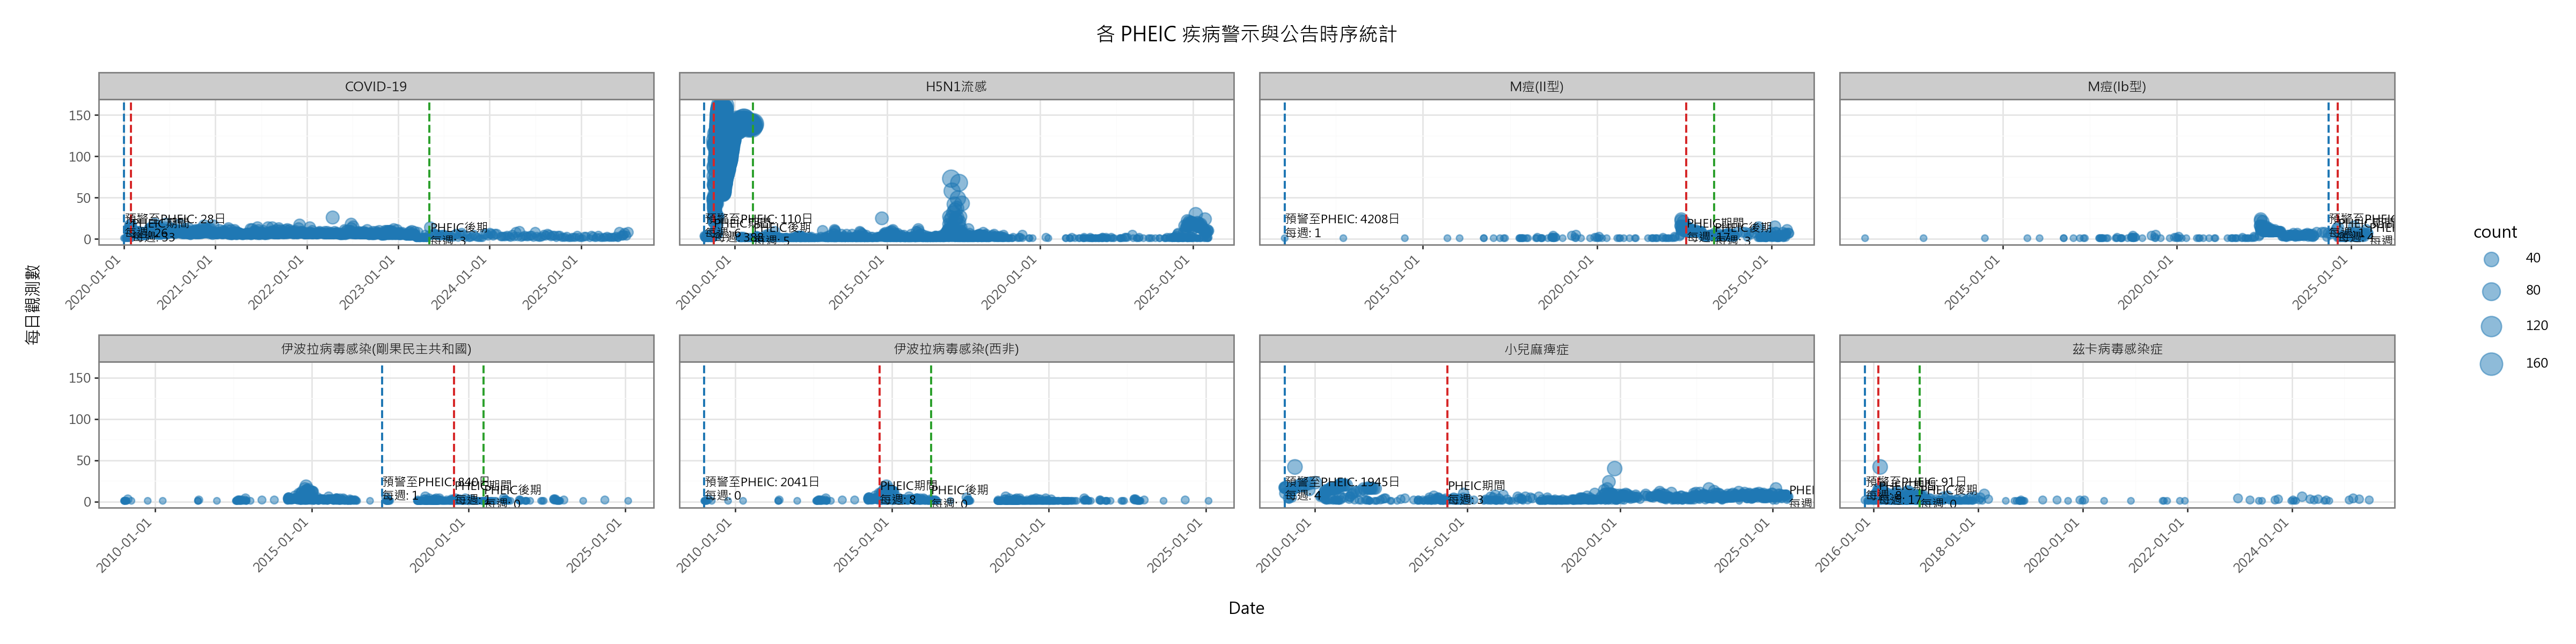

In [255]:
import pandas as pd
from plotnine import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體

# 確保日期格式正確
table_PHEIC_summary['date_PHEIC_start'] = pd.to_datetime(table_PHEIC_summary['date_PHEIC_start'])
table_PHEIC_summary['date_PHEIC_end'] = pd.to_datetime(table_PHEIC_summary['date_PHEIC_end'])
table_PHEIC_summary['date_CDC_initial_alert'] = pd.to_datetime(table_PHEIC_summary['date_CDC_initial_alert'])
table_PHEIC_summary['date_study_end'] = pd.to_datetime(table_PHEIC_summary['date_study_end'])
df_PHEIC['date'] = pd.to_datetime(df_PHEIC['date'])

# 為 df_PHEIC 加上 PHEIC_name (左側對應)，便於 facet wrap 使用
df_plot = df_PHEIC.merge(table_PHEIC_summary[['disease_name', 'PHEIC_name']], on='disease_name', how='left')

# 計算每日個數（bubble plot 將用）
df_plot_grouped = df_plot.groupby(['PHEIC_name', 'date']).size().reset_index(name='count')

# 建立每筆觀測對應的註解資料集 (包含標註文字)
annotation_rows = []
for i, row in table_PHEIC_summary.iterrows():
    start = row['date_PHEIC_start']
    alert = row['date_CDC_initial_alert']
    end = row['date_PHEIC_end']
    study_end = row['date_study_end']
    pname = row['PHEIC_name']

    def safe_get(x):
        return int(x) if pd.notnull(x) else 0

    annotation_rows += [
        {'PHEIC_name': pname, 'x': alert + pd.Timedelta(days=3), 'y': 30,
         'label': f"預警至PHEIC: {safe_get(row['interval_days_alert_to_start'])}日\n每週: {safe_get(row['avg_weekly_obs_alert_to_start'])}"},
        {'PHEIC_name': pname, 'x': start + pd.Timedelta(days=3), 'y': 25,
         'label': f"PHEIC期間\n每週: {safe_get(row['avg_weekly_obs_start_to_end'])}"},
        {'PHEIC_name': pname, 'x': (end if pd.notnull(end) else study_end) + pd.Timedelta(days=3), 'y': 20,
         'label': f"PHEIC後期\n每週: {safe_get(row['avg_weekly_obs_end_to_study'])}"}
    ]

df_annotations = pd.DataFrame(annotation_rows)

# 建立日期線的資料
df_lines = pd.melt(table_PHEIC_summary,
                   id_vars=['PHEIC_name'],
                   value_vars=['date_CDC_initial_alert', 'date_PHEIC_start', 'date_PHEIC_end'],
                   var_name='line_type', value_name='date')
df_lines = df_lines.dropna(subset=['date'])

# 顏色對應每種線型
line_color_map = {
    'date_CDC_initial_alert': '#1f77b4',  # blue
    'date_PHEIC_start': '#d62728',        # red
    'date_PHEIC_end': '#2ca02c'           # green
}

# 主要圖形繪製
p = (
    ggplot(df_plot_grouped, aes(x='date', y='count')) +
    geom_point(aes(size='count'), alpha=0.5, color='#1f78b4') +
    facet_wrap('~PHEIC_name', scales='free_x', nrow=2, ncol = 4) +

    # 關鍵時間線
    geom_vline(df_lines,
               aes(xintercept='date', color='line_type'),
               linetype='dashed', size=0.8, show_legend=False) +

    # 標註文字
    geom_text(df_annotations, aes(x='x', y='y', label='label'),
              ha='left', va='top', size=8, color='black') +

    # 顏色自定義
    scale_color_manual(values=line_color_map) +
    scale_size_continuous(range=[2, 8]) +

    labs(title='各 PHEIC 疾病警示與公告時序統計',
         x='Date', y='每日觀測數') +

    theme_bw() +
    theme(figure_size=(24, 6),
          axis_text_x=element_text(rotation=45, hjust=1),
          subplots_adjust={'wspace': 0.25},
           text=element_text(family="Microsoft JhengHei"))
)

p.show()
#p.save("plot/pheic_timeline_plot.png", dpi=300)

